In [1]:
import sys
sys.path.append("..")

In [3]:
import os

# prevent JAX from preallocating all GPU memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# data loading
import pandas as pd
import numpy as np

# plotting
#import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

# pyro
import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive
from numpyro.handlers import condition, trace
from numpyro.contrib.control_flow import scan, cond

numpyro.set_host_device_count(4)

# jax
import jax
import jax.numpy as jnp
import jax.random as random

if any([d.platform == "gpu" for d in jax.devices()]):
    numpyro.set_platform("gpu")

from jax.lib import xla_bridge
print(f"current XLA device: {xla_bridge.get_backend().platform}")

import weathergen as wx
import wxsbi

C:\Users\jw1301\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


current XLA device: cpu


In [4]:
# enable autoreload of source files
%load_ext autoreload
%autoreload 2

Here we auto-download the E-OBS basin data, if necessary.

# Data

In [26]:
basin_id = 6340800
basin_info = pd.read_csv("../data/eobs-basins/basins_info.csv")
name_map = wx.data.data_var_name_map(prec="pre", Tair_mean="tavg", Tair_min="tmin", Tair_max="tmax")
basin_data_all = wx.data.load_time_series_csv("../data/eobs-basins/eobs_basins_averaged_all.csv", name_map)


In [27]:
basin_data = basin_data_all.loc[basin_data_all.id == basin_id].drop(columns=basin_data_all.columns[0])

In [28]:
basin_info[basin_info.id == basin_id]

id  wmo_reg  sub_reg  river    station country     lat    lon  \
531  6340800        6     6401  SPREE  SPREMBERG      DE  51.577  14.37   

       area  altitude_station  ...  r_volume_yr  r_height_yr      clay  \
531  2092.0             91.52  ...     0.505018   241.404161  0.142248   

         sand  mineral_bulk_density  altitude_basin    forest  impervious  \
531  0.526502              0.012846      206.270072  0.386012    0.024523   

     pervious     slope  
531  0.589464  2.507489  

[1 rows x 32 columns]

In [29]:
basin_data_train = basin_data["1950":"1980"]

Tair_freqs = [1/356.25, 2/365.25]
prec_freqs = [1/365.25, 2/365.25, 3/365.25]


# Model

In [31]:
from weathergen.wgen.wgen_gamlss import *

In [32]:
import pandas as pd

from abc import ABC

import jax
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.handlers import mask

class WGEN_GAMLSS(ABC):

    def get_initial_states(self, obs_or_shape: dict | tuple[int, int], order=1, dropna=True):
        if isinstance(obs_or_shape, tuple):
            # default to batch_size = 1 and one time step
            return jnp.zeros((*obs_or_shape, order, 2))
        # initialize from observations
        obs = obs_or_shape
        prec_state = jnp.expand_dims(obs["prec"], axis=[-1, -2])
        Tavg_state = jnp.expand_dims(obs["Tavg"], axis=[-1, -2])
        Trange_state = jnp.expand_dims(obs["Trange"], axis=[-1, -2])
        state = jnp.concat([prec_state, Tavg_state, Trange_state], axis=-2)
        # concatenate lagged states
        timelen = state.shape[1]
        return jnp.concat([state[:, i : timelen - order + i, :, :] for i in range(order)], axis=-1)

    def get_obs(self, data: pd.DataFrame):
        """Returns the observations"""

        prec_obs = data["prec"]
        Tavg_obs = data["Tair_mean"]
        Trange_obs = data["Tair_max"] - data["Tair_min"]
        Tskew_obs = (Tavg_obs - data["Tair_min"]) / Trange_obs
        return {
            "prec": jnp.array(prec_obs.values).reshape((1, -1)),
            "Tavg": jnp.array(Tavg_obs.values).reshape((1, -1)),
            "Trange": jnp.array(Trange_obs.values).reshape((1, -1)),
            "Tskew": jnp.array(Tskew_obs.values).reshape((1, -1)),
        }

    def prior(
        self,
        predictors,
        initial_states,
        pred_effect_scale=jnp.ones(1),
        Tskew_scaled_dispersion_mean=1.0,
        Tair_freqs=[1 / 365.25],
        prec_freqs=[1 / 365.25],
        **kwargs,
    ):
        """Improved WGEN-GLM which generates daily weather variables according to the following procedure:
            1) Tavg(t) | Tavg(t-1), ...,Tavg(t-n)
            2) prec | prec(t-1), ..., prec(t-n), Tavg(t-1), ...,Tavg(t-n)
            3) Trange | prec, Tavg
            4) Tskew | prec, Tavg

            Mean daily air temperature is modelled as Student-T distribution with variable degrees of freedom.
            Precipitation is modelled as a bernoulli-Gamma mixture distribution.
            Daily air temperature range is modelled as a Gamma distribution.
            Daily air temperature skewness is modeled as a Beta distribution.

            Each of these observable variables are parameterized as GLMs defined over some set of linear predictors.

        Args:
            num_predictors (int, optional): number of exogeneous predictors. Defaults to 1.
            Tavg_dof_mean (float, optional): if not None, specifies the prior mean of the DoF parameter for a Student-t likelihood. Defaults to None, i.e. Gaussian likelihood.
            pred_effect_scale (float, optional): standard deviation of the predictor effect prior. Defaults to 1.0.
            Tskew_scaled_dispersion_mean (float, optional): prior mean of the Tskew dispersion parameter. Defaults to 1.0.
            Tair_freqs (list, optional): frequencies for air temperature seasonal effects. Defaults to the annual cycle: [1/365.25].
            prec_freqs (list, optional): frequencies for precipitation seasonal effects. Defaults to the annual cycle: [1/365.25].

        Returns:
            _type_: _description_
        """
        num_predictors = predictors.shape[-1]
        order = initial_states.shape[-1]
        assert num_predictors > 0, "number of predictors must be greater than zero"

        # mean air temperature
        tair_mean_step = wgen_glm_v5_Tair_mean(
            num_predictors,
            pred_effect_scale,
            freqs=Tair_freqs,
            order=order,
            **kwargs,
        )
        # precipitation
        precip_step = wgen_glm_v5_precip(num_predictors, pred_effect_scale, freqs=prec_freqs, order=order, **kwargs)
        # air temperature range and skew
        tair_range_skew_step = wgen_glm_v5_Tair_range_skew(
            num_predictors,
            pred_effect_scale,
            Tskew_scaled_dispersion_mean,
            freqs=Tair_freqs,
            order=order,
            **kwargs,
        )

        def step(state, inputs, obs={"prec": None, "Tavg": None, "Trange": None, "Tskew": None}):
            assert state.shape[0] == inputs.shape[0], "state and input batch dimensions do not match"
            assert state.shape[2] == order, f"state lag dimension does not match order={order}"
            # unpack state and input tensors;
            # state is assumed to have shape (batch, vars, lag)
            prec_prev = state[:, 0, :]
            Tavg_prev = state[:, 1, :]
            Trange_prev = state[:, 2, :]
            # i, year, month, doy = inputs[:, :4].T
            # predictors = inputs[:, 4:]
            # mean daily air temperature
            Tavg = tair_mean_step(Tavg_prev, inputs, obs["Tavg"])  # Tavg_loc, Tavg_seasonal_anomaly
            Tavg_for_precip = Tavg.reshape((-1, 1))  # Tavg_seasonal_anomaly.reshape((-1, 1))
            # precipitation
            prec = precip_step((prec_prev, Tavg_for_precip), inputs, obs["prec"])
            # air temperature range and skew
            Trange, Tskew, Tmin, Tmax = tair_range_skew_step(
                (Tavg, prec, Trange_prev), inputs, obs["Trange"], obs["Tskew"]
            )
            newstate = jnp.expand_dims(jnp.stack([prec, Tavg, Trange]).T, axis=-1)
            return jnp.concat([state[:, :, 1:], newstate], axis=-1), (prec, Tmin, Tavg, Tmax)

        return step


def wgen_glm_v5_Tair_mean(
    num_predictors: int = 1,
    pred_effect_scale=jnp.ones(1),
    freqs=[1 / 365.25, 2 / 365.2],
    order=1,
    Tavg_lag_in_scale=False,
    **kwargs,
):
    seasonal_dims = 2 * len(freqs)

    # Location
    Tavg_loc_lag_effects = numpyro.sample(
        "Tavg_loc_lag", dist.MultivariateNormal(jnp.zeros(order), 0.2 * jnp.eye(order))
    )
    Tavg_loc_seasonal_effects = numpyro.sample(
        "Tavg_loc_seasonal",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims), jnp.eye(seasonal_dims)),
    )
    Tavg_loc_seasonal_lag_interaction_effects = numpyro.sample(
        "Tavg_loc_seasonal_lag_interaction",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims * order), jnp.eye(seasonal_dims * order)),
    )
    Tavg_loc_pred_effects = numpyro.sample(
        "Tavg_loc_pred",
        dist.MultivariateNormal(jnp.zeros(num_predictors), jnp.diag(pred_effect_scale)),
    )
    Tavg_loc_effects = jnp.concat(
        [
            Tavg_loc_seasonal_effects,
            Tavg_loc_lag_effects,
            Tavg_loc_seasonal_lag_interaction_effects,
            Tavg_loc_pred_effects,
        ],
        axis=-1,
    )

    ## Scale
    Tavg_scale_seasonal_effects = numpyro.sample(
        "Tavg_loc_scale_seasonal",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims), jnp.eye(seasonal_dims)),
    )
    Tavg_scale_pred_effects = numpyro.sample(
        "Tavg_loc_scale_pred",
        dist.MultivariateNormal(jnp.zeros(num_predictors), jnp.diag(pred_effect_scale)),
    )
    if Tavg_lag_in_scale:
        Tavg_scale_lag_effects = numpyro.sample(
            "Tavg_scale_lag", dist.MultivariateNormal(jnp.zeros(order), 0.2 * jnp.eye(order))
        )
        Tavg_scale_effects = jnp.concat(
            [Tavg_scale_seasonal_effects, Tavg_scale_lag_effects, Tavg_scale_pred_effects], axis=-1
        )
    else:
        Tavg_scale_effects = jnp.concat([Tavg_scale_seasonal_effects, Tavg_scale_pred_effects], axis=-1)

    def step(state, inputs, Tavg_obs=None):
        Tavg_prev = state
        i, year, month, doy = inputs[:, :4].T
        predictors = inputs[:, 4:]

        ff_t = utils.fourier_feats(i, freqs, intercept=False) * jnp.ones((Tavg_prev.shape[0], 1))
        seasonal_lag_interactions = jnp.concat([ff_t * Tavg_prev[:, i : (i + 1)] for i in range(order)], axis=1)

        Tavg_loc_features = jnp.concat([ff_t, Tavg_prev, seasonal_lag_interactions, predictors], axis=1)

        if Tavg_lag_in_scale:
            Tavg_scale_features = jnp.concat([ff_t, jnp.log(jnp.square(Tavg_prev)), predictors], axis=1)
        else:
            Tavg_scale_features = jnp.concat([ff_t, predictors], axis=1)

        Tavg_loc = numpyro.deterministic(
            "Tavg_loc",
            jnp.sum(Tavg_loc_features * Tavg_loc_effects, axis=1),
        )
        Tavg_scale = numpyro.deterministic(
            "Tavg_scale",
            jnp.exp(jnp.sum(Tavg_scale_features * Tavg_scale_effects, axis=1)),
        )

        # Sample Tavg
        Tavg_mask = jnp.isfinite(Tavg_obs) if Tavg_obs is not None else True
        with mask(mask=Tavg_mask):
            Tavg = numpyro.sample("Tavg", dist.Normal(Tavg_loc, Tavg_scale), obs=Tavg_obs)

        Tavg_sample_seasonal_anomaly = numpyro.deterministic(
            "Tavg_sample_seasonal_anomaly", Tavg - jnp.sum(Tavg_loc_seasonal_effects * ff_t, axis=1)
        )
        return Tavg  # , Tavg_loc, Tavg_sample_seasonal_anomaly

    return step


def wgen_glm_v5_precip(
    num_predictors: int = 1,
    pred_effect_scale=jnp.ones(1),
    freqs=[1 / 365.25],
    order=1,
    **kwargs,
):
    seasonal_dims = 2 * len(freqs)

    # Occurrence
    precip_occ_seasonal_effects = numpyro.sample(
        "precip_occ_seasonal",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims), jnp.eye(seasonal_dims)),
    )
    precip_occ_lag_effects = numpyro.sample(
        "precip_occ_lag",
        dist.MultivariateNormal(jnp.zeros(2 * order), 0.2 * jnp.eye(2 * order)),
    )
    precip_occ_lag_seasonal_interaction_effects = numpyro.sample(
        "precip_occ_lag_seasonal_interaction",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims * order * 2), 0.2 * jnp.eye(seasonal_dims * order * 2)),
    )
    precip_occ_Tavg_effects = numpyro.sample("precip_occ_Tavg", dist.MultivariateNormal(jnp.zeros(1), 0.1 * jnp.eye(1)))
    precip_occ_Tavg_seasonal_interaction_effects = numpyro.sample(
        "precip_occ_Tavg_seasonal_interaction", dist.MultivariateNormal(jnp.zeros(2), 0.1 * jnp.eye(2))
    )
    precip_occ_pred_effects = numpyro.sample(
        "precip_occ_pred",
        dist.MultivariateNormal(jnp.zeros(num_predictors), jnp.diag(pred_effect_scale)),
    )
    precip_occ_all_effects = jnp.concat(
        [
            precip_occ_seasonal_effects,
            precip_occ_lag_effects,
            precip_occ_lag_seasonal_interaction_effects,
            precip_occ_Tavg_effects,
            precip_occ_Tavg_seasonal_interaction_effects,
            precip_occ_pred_effects,
        ],
        axis=-1,
    )

    # Amounts: location
    precip_loc_seasonal_effects = numpyro.sample(
        "precip_loc_seasonal",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims), jnp.eye(seasonal_dims)),
    )
    precip_loc_Tavg_effects = numpyro.sample("precip_loc_Tavg", dist.MultivariateNormal(jnp.zeros(1), 0.1 * jnp.eye(1)))
    precip_loc_Tavg_seasonal_interaction_effects = numpyro.sample(
        "precip_loc_Tavg_seasonal_interaction", dist.MultivariateNormal(jnp.zeros(2), 0.1 * jnp.eye(2))
    )
    precip_loc_lag_effects = numpyro.sample(
        "precip_loc_lag",
        dist.MultivariateNormal(jnp.zeros(order), 0.2 * jnp.eye(order)),
    )
    precip_loc_lag_seasonal_interaction_effects = numpyro.sample(
        "precip_loc_lag_seasonal_interaction",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims * order), 0.2 * jnp.eye(seasonal_dims * order)),
    )
    precip_loc_pred_effects = numpyro.sample(
        "precip_loc_pred",
        dist.MultivariateNormal(jnp.zeros(num_predictors), jnp.diag(pred_effect_scale)),
    )
    precip_loc_all_effects = jnp.concat(
        [
            precip_loc_seasonal_effects,
            precip_loc_lag_effects,
            precip_loc_lag_seasonal_interaction_effects,
            precip_loc_Tavg_effects,
            precip_loc_Tavg_seasonal_interaction_effects,
            precip_loc_pred_effects,
        ],
        axis=-1,
    )
    # Amounts shape
    precip_shape_seasonal_effects = numpyro.sample(
        "precip_shape_seasonal",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims), jnp.eye(seasonal_dims)),
    )
    precip_shape_pred_effects = numpyro.sample(
        "precip_shape_pred",
        dist.MultivariateNormal(jnp.zeros(num_predictors), jnp.diag(pred_effect_scale)),
    )
    precip_shape_all_effects = jnp.concat(
        [
            precip_shape_seasonal_effects,
            precip_shape_pred_effects,
        ],
        axis=-1,
    )

    def step(state, inputs, prec_obs=None):
        prec_prev, Tavg = state
        i, year, month, doy = inputs[:, :4].T
        predictors = inputs[:, 4:]

        Tavg = jnp.sign(Tavg) * jnp.log(jnp.square(Tavg)) / 2

        prev_dry = 1 - jnp.sign(prec_prev)
        log_prec_prev = jnp.log(1 + prec_prev)

        ff_t = utils.fourier_feats(i, freqs, intercept=False) * jnp.ones((prec_prev.shape[0], 1))

        # Seasonal interactions
        seasonal_lag_interactions_amounts = jnp.concat(
            [ff_t * log_prec_prev[:, i : (i + 1)] for i in range(order)], axis=1
        )
        seasonal_lag_interactions_occ = jnp.concat([ff_t * prev_dry[:, i : (i + 1)] for i in range(order)], axis=1)
        seasonal_Tavg_interactions = (
            utils.fourier_feats(i, freqs=[1 / 365.25], intercept=False) * jnp.ones((prec_prev.shape[0], 1)) * Tavg
        )

        prec_occ_features = jnp.concat(
            [
                ff_t,
                prev_dry,
                log_prec_prev,
                seasonal_lag_interactions_occ,
                seasonal_lag_interactions_amounts,
                Tavg,
                seasonal_Tavg_interactions,
                predictors,
            ],
            axis=1,
        )
        prec_mean_features = jnp.concat(
            [
                ff_t,
                log_prec_prev,
                seasonal_lag_interactions_amounts,
                Tavg,
                seasonal_Tavg_interactions,
                predictors,
            ],
            axis=1,
        )
        prec_shape_features = jnp.concat([ff_t, predictors], axis=1)

        # Parameters
        p_wet = numpyro.deterministic(
            "p_wet", jax.nn.sigmoid(jnp.sum(prec_occ_features * precip_occ_all_effects, axis=1))
        )
        precip_gamma_loc = jnp.exp(jnp.sum(prec_mean_features * precip_loc_all_effects, axis=1))
        precip_gamma_shape = numpyro.deterministic(
            "precip_gamma_shape", jnp.exp(jnp.sum(prec_shape_features * precip_shape_all_effects, axis=1))
        )
        precip_gamma_rate = numpyro.deterministic("precip_gamma_rate", precip_gamma_shape / precip_gamma_loc)

        # Sample precipication from bernoulli-gamma with prob p_wet
        prec_occ_obs = prec_obs > 0.0 if prec_obs is not None else None
        prec_mask = prec_occ_obs if prec_occ_obs is not None else True
        with mask(mask=jnp.isfinite(prec_obs) if prec_obs is not None else True):
            prec_occ = numpyro.sample("prec_occ", dist.Bernoulli(p_wet), obs=prec_occ_obs)
        with mask(mask=prec_mask):
            prec_amount = numpyro.sample(
                "prec_amount",
                dist.Gamma(precip_gamma_shape, precip_gamma_rate),
                obs=prec_obs,
            )
        prec = numpyro.deterministic("prec", jnp.where(prec_occ, prec_amount, 0.0))
        return prec

    return step


def wgen_glm_v5_Tair_range_skew(
    num_predictors: int = 1,
    pred_effect_scale=1.0,
    Tskew_scaled_dispersion_mean=1.0,
    freqs=[1 / 365.25],
    order=1,
    Trange_max=22.0,
    **kwargs,
):
    ## Trange alpha
    freqs = [
        1 / 365.25,
        2 / 365.25,
    ]  # 3/365.25]
    seasonal_dims = 2 * len(freqs)
    Trange_alpha_seasonal_effects = numpyro.sample(
        "Trange_alpha_seasonal",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims), jnp.eye(seasonal_dims)),
    )
    Trange_alpha_Trange_prev_effects = numpyro.sample(
        "Trange_alpha_Trange_prev", dist.MultivariateNormal(jnp.zeros(order), 0.1 * jnp.eye(order))
    )
    Trange_alpha_pred_effects = numpyro.sample(
        "Trange_alpha_pred",
        dist.MultivariateNormal(jnp.zeros(num_predictors), jnp.diag(pred_effect_scale)),
    )
    Trange_alpha_seasonal_lag_interaction_effects = numpyro.sample(
        "Trange_alpha_seasonal_lag_interaction",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims * order), 0.2 * jnp.eye(seasonal_dims * order)),
    )
    Trange_alpha_all_effects = jnp.concat(
        [
            Trange_alpha_seasonal_effects,
            Trange_alpha_Trange_prev_effects,
            Trange_alpha_seasonal_lag_interaction_effects,
            Trange_alpha_pred_effects,
        ],
        axis=-1,
    )
    ## Trange beta
    Trange_beta_seasonal_effects = numpyro.sample(
        "Trange_beta_seasonal",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims), jnp.eye(seasonal_dims)),
    )
    Trange_beta_Trange_prev = numpyro.sample(
        "Trange_beta_Trange_prev", dist.MultivariateNormal(jnp.zeros(order), 0.2 * jnp.eye(order))
    )
    Trange_beta_pred_effects = numpyro.sample(
        "Trange_beta_pred",
        dist.MultivariateNormal(jnp.zeros(num_predictors), jnp.diag(pred_effect_scale)),
    )
    Trange_beta_seasonal_lag_interaction_effects = numpyro.sample(
        "Trange_beta_seasonal_lag_interaction",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims * order), 0.2 * jnp.eye(seasonal_dims * order)),
    )
    Trange_beta_all_effects = jnp.concat(
        [
            Trange_beta_seasonal_effects,
            Trange_beta_Trange_prev,
            Trange_beta_seasonal_lag_interaction_effects,
            Trange_beta_pred_effects,
        ],
        axis=-1,
    )

    ## Tskew alpha
    Tskew_alpha_seasonal_effects = numpyro.sample(
        "Tskew_alpha_seasonal",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims), jnp.eye(seasonal_dims)),
    )
    Tskew_alpha_Tavg_effects = numpyro.sample(
        "Tskew_alpha_Tavg", dist.MultivariateNormal(jnp.zeros(1), 0.1 * jnp.eye(1))
    )
    Tskew_alpha_pred_effects = numpyro.sample(
        "Tskew_alpha_pred",
        dist.MultivariateNormal(jnp.zeros(num_predictors), jnp.diag(pred_effect_scale)),
    )
    Tskew_alpha_all_effects = jnp.concat(
        [
            Tskew_alpha_seasonal_effects,
            Tskew_alpha_Tavg_effects,
            Tskew_alpha_pred_effects,
        ],
        axis=-1,
    )
    ## Tskew beta
    Tskew_beta_seasonal_effects = numpyro.sample(
        "Tskew_beta_seasonal",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims), jnp.eye(seasonal_dims)),
    )
    Tskew_beta_Tavg_effects = numpyro.sample("Tskew_beta_Tavg", dist.MultivariateNormal(jnp.zeros(1), 0.1 * jnp.eye(1)))
    Tskew_beta_pred_effects = numpyro.sample(
        "Tskew_beta_pred",
        dist.MultivariateNormal(jnp.zeros(num_predictors), jnp.diag(pred_effect_scale)),
    )
    Tskew_beta_all_effects = jnp.concat(
        [
            Tskew_beta_seasonal_effects,
            Tskew_beta_Tavg_effects,
            Tskew_beta_pred_effects,
        ],
        axis=-1,
    )

    def step(state, inputs, Trange_obs=None, Tskew_obs=None):

        Trange_obs_scaled = Trange_obs
        if Trange_obs is not None:
            # Rescale to [0, 1]
            Trange_obs_scaled = Trange_obs / Trange_max

        Tavg, prec, Trange_prev = state
        Trange_prev_scaled = Trange_prev / Trange_max
        i, year, month, doy = inputs[:, :4].T
        predictors = inputs[:, 4:]
        ff_t = utils.fourier_feats(i, freqs, intercept=False) * jnp.ones((Tavg.shape[0], 1))

        # Features
        Trange_features = jnp.concat(
            [
                ff_t,
                jnp.log(Trange_prev_scaled),
                jnp.concat([ff_t * Trange_prev_scaled[:, i : (i + 1)] for i in range(order)], axis=1),
                predictors,
            ],
            axis=1,
        )
        Tskew_features = jnp.concat([ff_t, Tavg.reshape((-1, 1)), predictors], axis=1)

        # Parameters Trange and Tskew
        Trange_alpha = jnp.exp(
            jnp.sum(Trange_features * Trange_alpha_all_effects, axis=1)
        )  # jax.scipy.special.expit *100
        Trange_beta = jnp.exp(jnp.sum(Trange_features * Trange_beta_all_effects, axis=1))  # *100

        Tskew_alpha = jnp.exp(jnp.sum(Tskew_features * Tskew_alpha_all_effects, axis=1))
        Tskew_beta = jnp.exp(jnp.sum(Tskew_features * Tskew_beta_all_effects, axis=1))

        # Sample
        Trange_mask = jnp.isfinite(Trange_obs) if Trange_obs is not None else True
        with mask(mask=Trange_mask):
            Trange_scaled = numpyro.sample(
                "Trange_scaled",
                dist.Beta(Trange_alpha, Trange_beta),
                obs=Trange_obs_scaled,
            )
            Trange = numpyro.deterministic("Trange", Trange_scaled * Trange_max)

        Tskew_mask = jnp.isfinite(Tskew_obs) if Tskew_obs is not None else True
        with mask(mask=Tskew_mask):
            Tskew = numpyro.sample(
                "Tskew",
                dist.Beta(Tskew_alpha, Tskew_beta),
                obs=Tskew_obs,
            )

        # calculate min and max from range and skew
        Tmin = numpyro.deterministic("Tmin", Tavg - Tskew * Trange)
        Tmax = numpyro.deterministic("Tmax", Tmin + Trange)
        return Trange, Tskew, Tmin, Tmax

    return step


In [33]:
#wgen = wx.WGEN(basin_data_train, model = wx.wgen_glm_v2, order = 2, Tair_freqs=Tair_freqs, prec_freqs=prec_freqs)
#wgen = wx.WGEN(basin_data_train, order = 2, Tair_freqs=Tair_freqs, prec_freqs=prec_freqs)
wgen = wx.WGEN(basin_data_train, model = WGEN_GAMLSS(), order = 2, Tair_freqs=[1/365.25, 2/365.25], prec_freqs=[1/365.25, 2/365.25])

In [119]:
wgen.initial_states.shape

(1, 11321, 3, 2)

Run variational inference for parameter estimates:

In [122]:
from numpyro.infer import SVI, TraceGraph_ELBO
from numpyro.infer.autoguide import AutoDelta, AutoNormal, AutoMultivariateNormal

num_iter = 50_000
prng = random.PRNGKey(1234)
guide = AutoMultivariateNormal(wgen.step, init_loc_fn=numpyro.infer.init_to_median)
svi_result = wgen.fit(num_iter, guide, subsample_time=1000, rng=prng)

100%|██████████| 50000/50000 [02:58<00:00, 279.94it/s, init loss: 412717.4062, avg. loss [47501-50000]: 28595.6737]


Get posterior samples:

In [124]:
posterior_sampler = Predictive(guide, params=svi_result.params, num_samples=100)
posterior_params = posterior_sampler(prng)
{k: v.mean(axis=0) for k,v in posterior_params.items() if k != "_auto_latent"}

{'Tavg_loc_lag': Array([-0.19764814,  0.9538096 ], dtype=float32),
 'Tavg_loc_pred': Array([2.398603], dtype=float32),
 'Tavg_loc_scale_pred': Array([0.79891247], dtype=float32),
 'Tavg_loc_scale_seasonal': Array([ 0.08220787, -0.01758923, -0.01478404,  0.04059773], dtype=float32),
 'Tavg_loc_seasonal': Array([-0.82781744,  0.16022445, -2.8345146 ,  0.22919525], dtype=float32),
 'Tavg_loc_seasonal_lag_interaction': Array([-0.00972907,  0.00190808, -0.03636055, -0.00216361,  0.04068361,
         0.00813558,  0.10666931,  0.005878  ], dtype=float32),
 'Trange_alpha_Trange_prev': Array([-0.00331521,  0.06602173], dtype=float32),
 'Trange_alpha_pred': Array([1.5269383], dtype=float32),
 'Trange_alpha_seasonal': Array([-0.0025383 ,  0.05841029,  0.16809437,  0.05800278], dtype=float32),
 'Trange_alpha_seasonal_lag_interaction': Array([-0.0361576 ,  0.01078807, -0.10422897, -0.02001565, -0.07563651,
        -0.15259765, -0.482323  , -0.08416206], dtype=float32),
 'Trange_beta_Trange_prev': A

Get predictive distributions and run simulations

In [126]:
svi_predictive = Predictive(wgen.simulate, posterior_samples=posterior_params, parallel=True)
svi_preds = svi_predictive(prng)

In [127]:
obs = wgen.obs

## Model diagnostics

In [129]:
from weathergen.plotting import *

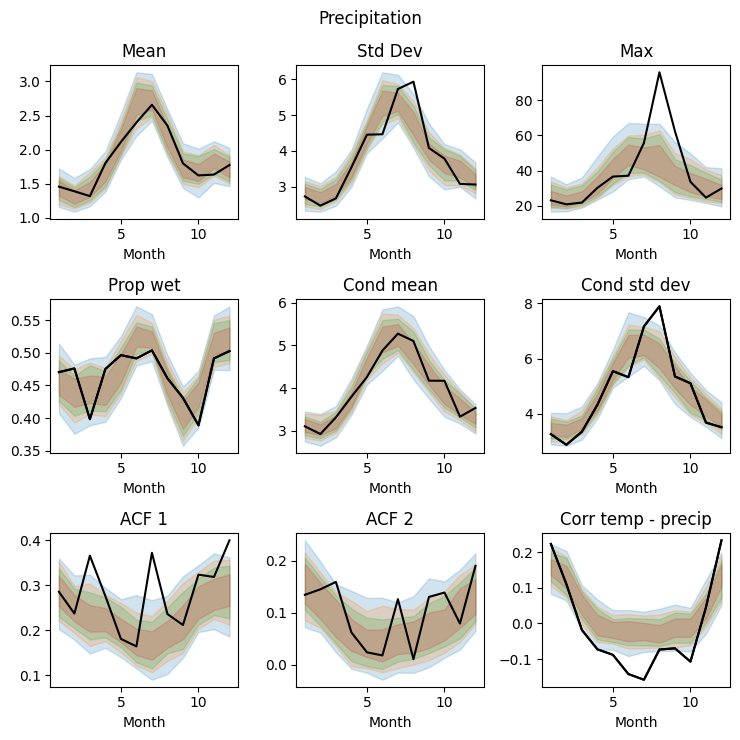

In [130]:
fig = plt.figure(layout="tight", figsize=(7.5, 7.5))
fig.suptitle("Precipitation")

gs = GridSpec(3, 3, figure=fig)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_1[0])
get_std_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_1[1])
get_max_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_1[2])

# Row 2
ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_prop_wet_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_2[0])
get_cond_mean_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_2[1])
get_cond_std_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_2[2])

# Row 3
ax_row_3 = [fig.add_subplot(gs[2, i]) for i in range(3)]
get_acf_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_3[0], lag=1)
get_acf_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_3[1], lag=2)
get_temp_precip_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_3[2])


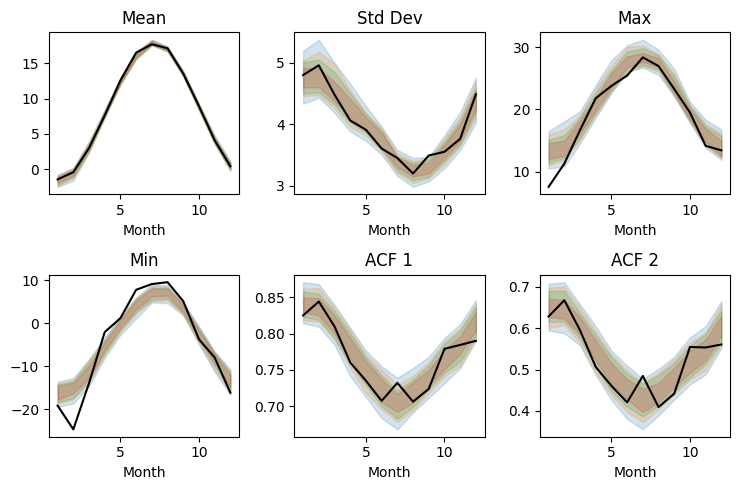

In [131]:
fig = plt.figure(layout="tight", figsize=(7.5, 5))
#fig.suptitle("Tavg")

gs = GridSpec(2, 3, figure=fig)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax=ax_row_1[0])
get_std_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax=ax_row_1[1])
get_max_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax=ax_row_1[2])

# Row 2
ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_min_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax=ax_row_2[0])
get_acf_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax=ax_row_2[1], lag=1)
get_acf_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax=ax_row_2[2], lag=2)


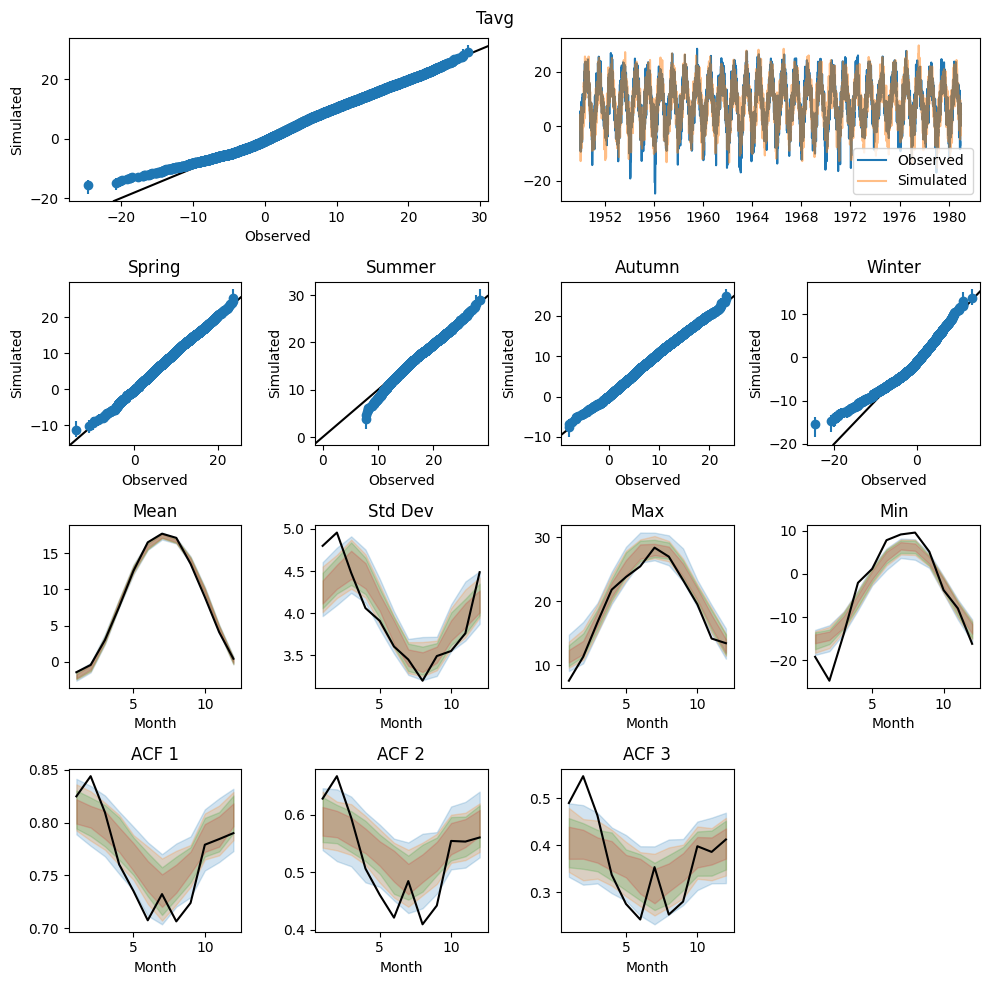

In [26]:
Tavg_overview(obs, svi_preds, basin_data_train)
#plt.savefig("plots/wgen_v5_Tavg.png")

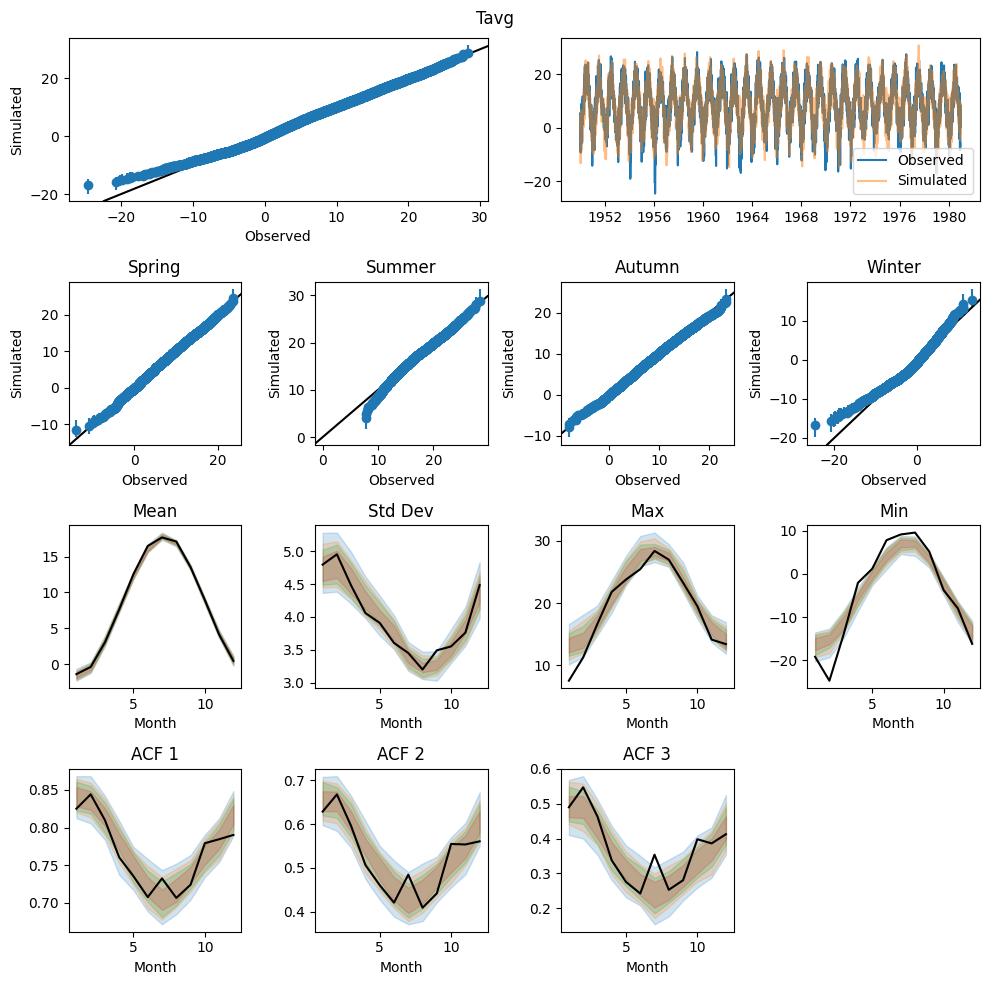

In [46]:
Tavg_overview(obs, svi_preds, basin_data_train)
#plt.savefig("plots/wgen_v5_Tavg.png")

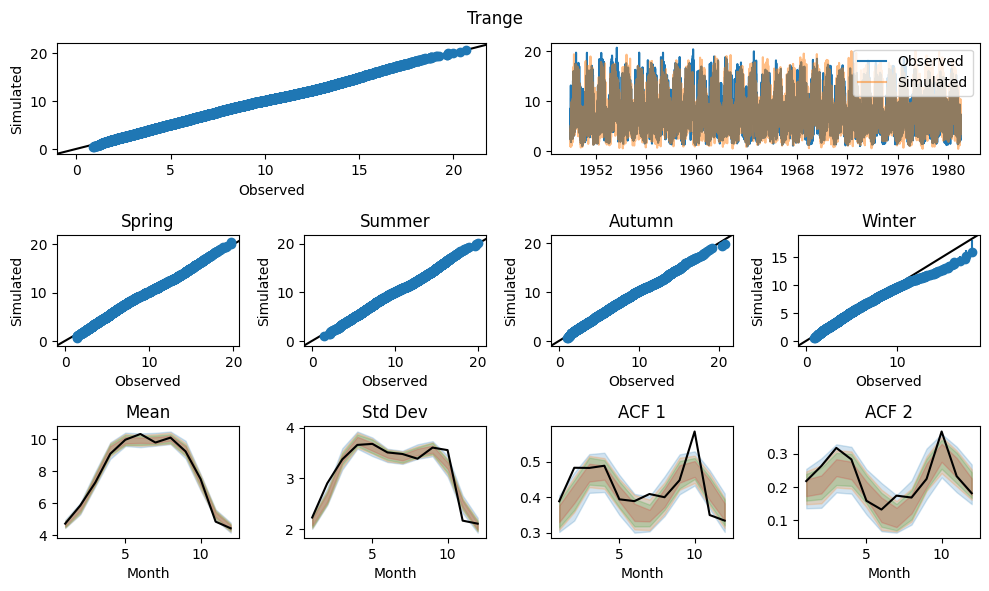

In [47]:
Trange_overview(obs, svi_preds, basin_data_train)
#plt.savefig("plots/wgen_v5_Trange.png")

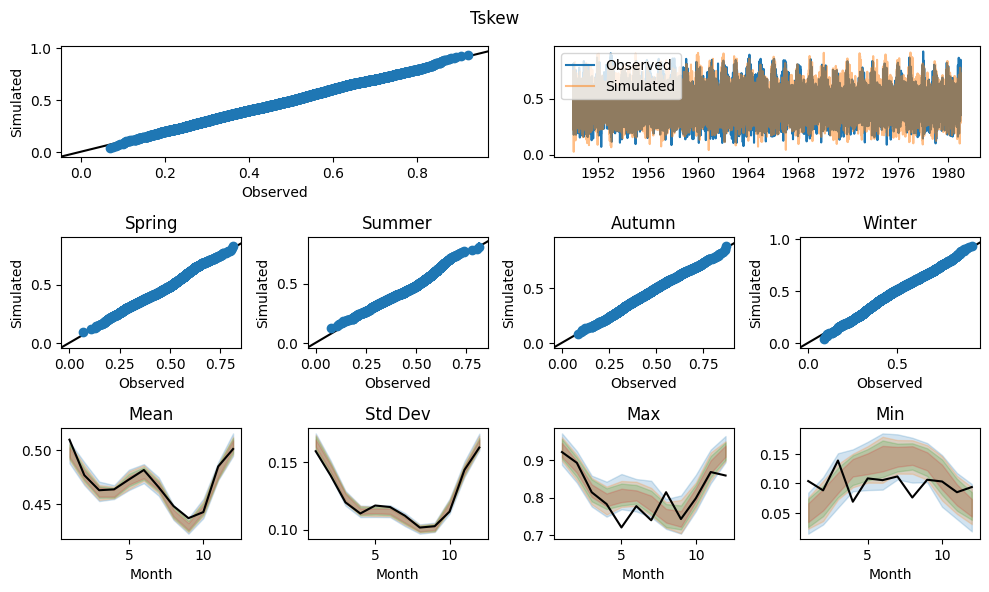

In [48]:
Tskew_overview(obs, svi_preds, basin_data_train)
#plt.savefig("plots/wgen_v5_Tskew.png")

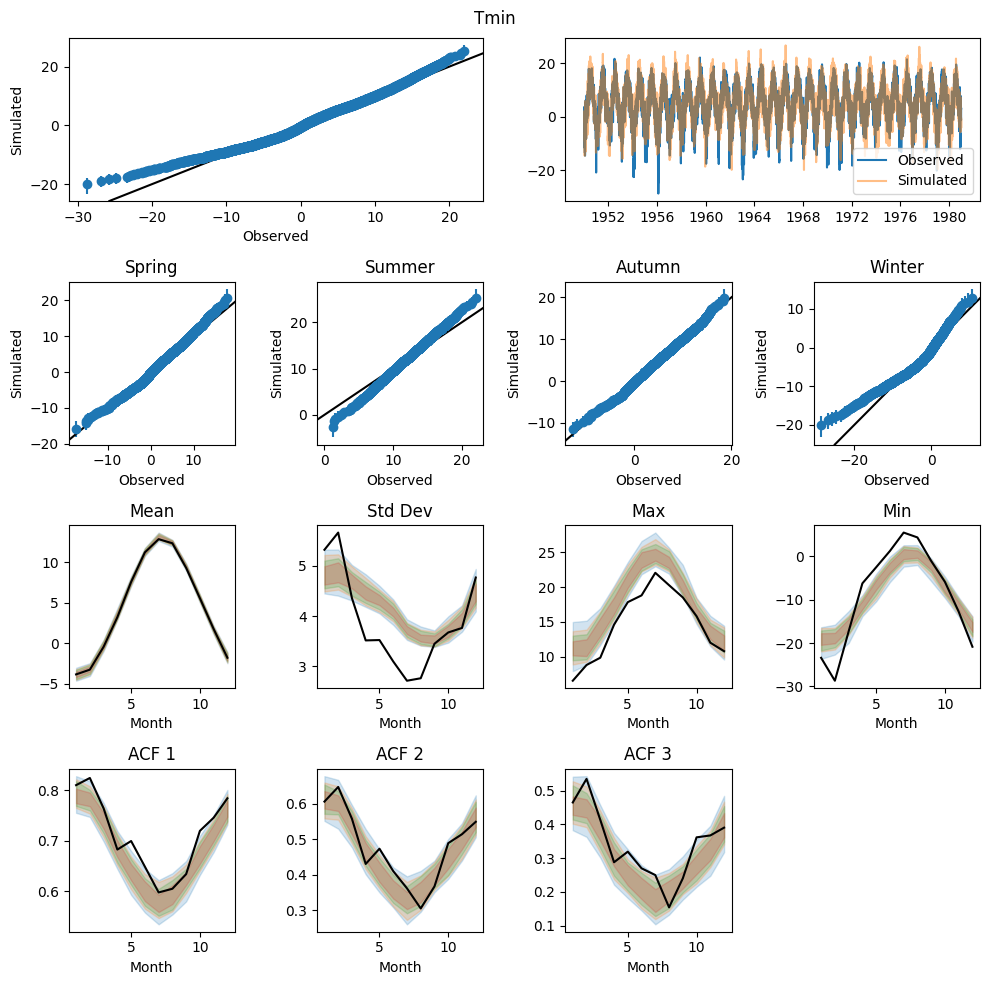

In [49]:
Tmin_overview(obs, svi_preds, basin_data_train)
#plt.savefig("plots/wgen_v5_Tmin.png")

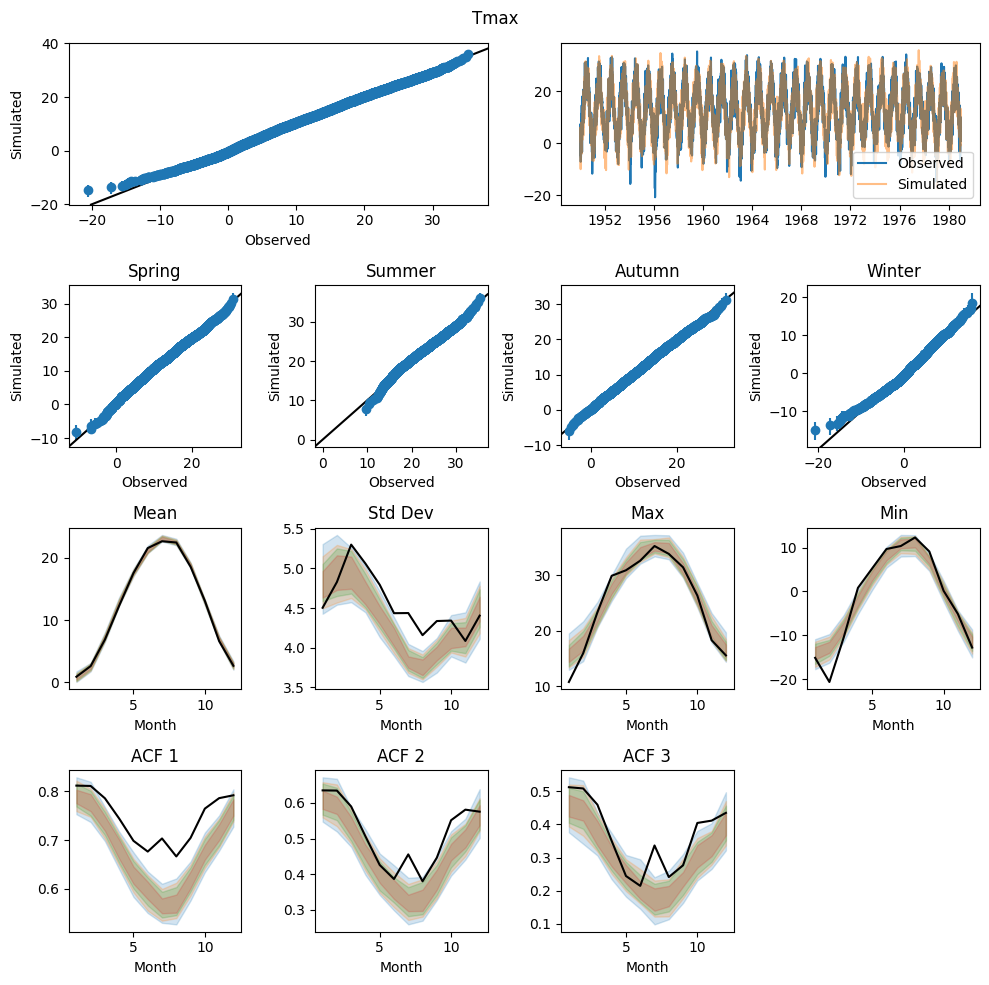

In [50]:
Tmax_overview(obs, svi_preds, basin_data_train)
#plt.savefig("plots/wgen_v5_Tmax.png")

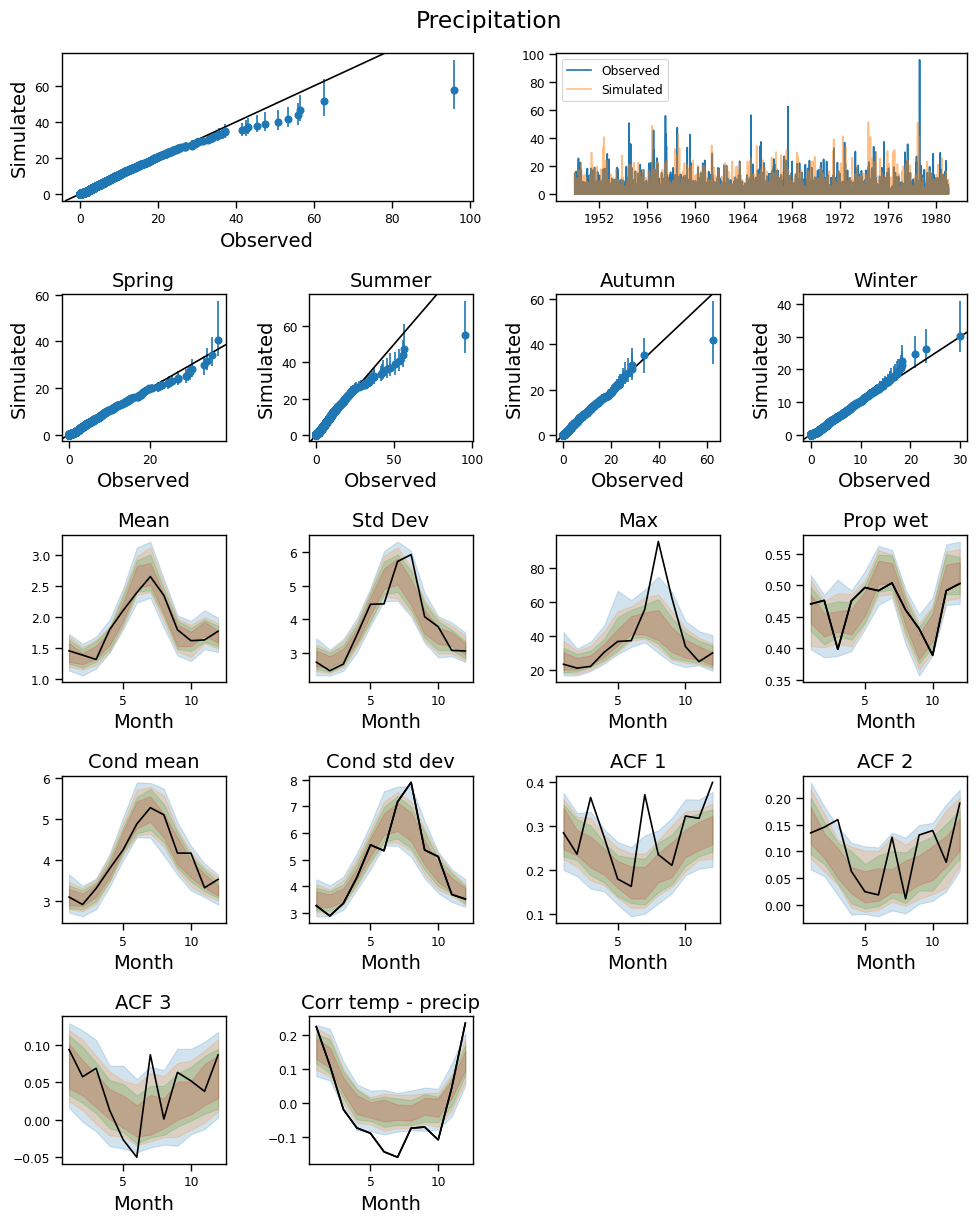

In [522]:
prec_overview(obs, svi_preds, basin_data_train)
plt.savefig("plots/wgen_v5_prec.png")

# SBI

In [132]:
import torch
from jax2torch.jax2torch import jax2torch, j2t, t2j
from sbi.inference import SNPE, SNLE, simulate_for_sbi
from sbi.utils.user_input_checks import process_prior, process_simulator

torch.manual_seed(1234)

In [133]:
def tair_summary_stats(Tair_mean, Tair_min, Tair_max):
    Tair90 = jnp.quantile(Tair_mean, 0.99, axis=0)
    Tair50 = jnp.quantile(Tair_mean, 0.50, axis=0)
    Tair10 = jnp.quantile(Tair_mean, 0.01, axis=0)
    Trange = jnp.mean(Tair_max - Tair_min, axis=0)
    Tskew = jnp.mean((Tair_mean - Tair_min) / (Tair_max - Tair_min), axis=0)
    tdd = jnp.mean(jnp.where(Tair_mean > 0, Tair_mean, 0), axis=0)
    fdd = jnp.mean(jnp.where(Tair_mean <= 0, Tair_mean, 0), axis=0)
    return jnp.stack([Tair10, Tair50, Tair90, Trange, Tskew, tdd, fdd])

def precip_summary_stats(pr, cdd_thresh=0.0, axis=0):
    pcondmean = jnp.nanmean(jnp.where(pr > 0, pr, jnp.nan), axis=axis)
    pmean = jnp.mean(pr, axis=axis)
    p95 = jnp.nanquantile(jnp.where(pr > 0, pr, jnp.nan), 0.95, axis=axis)
    rp95 = jnp.nanmean(jnp.where(pr > p95, pr, jnp.nan), axis=axis)
    fwd = jnp.mean(pr > 0, axis=axis)
    cdd = wx.utils.cumulative_dry_days(pr, threshold=cdd_thresh, axis=axis)
    return jnp.stack([pcondmean, pmean, rp95, fwd, cdd])

def wgen_summary_stats(ts, precip, Tmin, Tavg, Tmax):
    precip_stats = precip_summary_stats(precip)
    #Tair_stats = tair_summary_stats(Tavg, Tmin, Tmax)
    #return jnp.concat([precip_stats, Tair_stats], axis=0)
    return precip_stats[0:1, :]
    # return precip_stats

summary_stat_names = ["prec_mean", "rp95", "norm wet days", "mean dry spell length", "Tair_mean", "Tair_range", "Tair_skew", "norm thaw days"]

In [134]:
svi_preds["prec"].mean()

Array(1.8844491, dtype=float32)

## First example: same mean precip, but increase in 95th percentile and temperature

In [553]:
j2t(svi_posterior.mean).shape

torch.Size([113])

In [545]:
sbi_posterior_min_diff_sims

tensor([[ 2.0354,  2.1900,  2.4224,  ..., 10.3895, 19.9008, 13.1867],
        [ 2.0682,  2.3310,  2.5619,  ..., 10.6804, 20.0880, 13.3715],
        [ 2.1533,  2.4432,  2.3805,  ..., 10.4790, 19.7100, 13.4992],
        ...,
        [ 2.1250,  2.1111,  2.6447,  ..., 10.6331, 20.1745, 13.2695],
        [ 1.9437,  2.4373,  2.3673,  ..., 10.6736, 19.7008, 13.5573],
        [ 2.1655,  2.0738,  2.5239,  ..., 10.5921, 19.9231, 13.3464]])

In [541]:
case_study_2(wgen.timestamps[:, wgen.first_valid_idx :, :], *sbi_posterior_min_diff_sims)

TypeError: case_study_2() takes 5 positional arguments but 2001 were given

Non scaled up prior around parameters held constant:

- 20% increase in yearly average precip, but same number of dry days
- 3°C temperautre change

In [383]:
def case_study_2(ts, precip, Tmin, Tavg, Tmax):
    winter = jnp.isin(ts[:, :, 2], jnp.array([12, 1, 2])).T
    spring = jnp.isin(ts[:, :, 2], jnp.array([3, 4, 5])).T
    summer = jnp.isin(ts[:, :, 2], jnp.array([6, 7, 8])).T
    autumn = jnp.isin(ts[:, :, 2], jnp.array([9, 10, 11])).T

    pmean_winter = jnp.nanmean(jnp.where(winter, precip, jnp.nan), axis = 0)
    pmean_spring = jnp.nanmean(jnp.where(spring, precip, jnp.nan), axis = 0)
    pmean_summer = jnp.nanmean(jnp.where(summer, precip, jnp.nan), axis = 0)
    pmean_autumn = jnp.nanmean(jnp.where(autumn, precip, jnp.nan), axis = 0)

    wet = (precip > 0)
    pavgwet_winter = jnp.nanmean(jnp.where(winter, wet, jnp.nan), axis = 0)
    pavgwet_spring = jnp.nanmean(jnp.where(spring, wet, jnp.nan), axis = 0)
    pavgwet_summer = jnp.nanmean(jnp.where(summer, wet, jnp.nan), axis = 0)
    pavgwet_autumn = jnp.nanmean(jnp.where(autumn, wet, jnp.nan), axis = 0)
    
    Tavg_winter = jnp.nanmean(jnp.where(winter, Tavg, jnp.nan), axis = 0)
    Tavg_spring = jnp.nanmean(jnp.where(spring, Tavg, jnp.nan), axis = 0)
    Tavg_summer = jnp.nanmean(jnp.where(summer, Tavg, jnp.nan), axis = 0)
    Tavg_autumn = jnp.nanmean(jnp.where(autumn, Tavg, jnp.nan), axis = 0)

    #icy_days = jnp.mean(Tmax < 0, axis = 0)
    #heavy_rain = jnp.mean(precip > 20, axis = 0)

    return jnp.stack([pmean_winter, pmean_spring, pmean_summer, pmean_autumn, pavgwet_winter, pavgwet_spring, pavgwet_summer, pavgwet_autumn, Tavg_winter, Tavg_spring, Tavg_summer, Tavg_autumn])#, icy_days])

In [385]:
obs['Tmin'] = obs['Tavg'] - obs['Tskew']*obs['Trange']
obs['Tmax'] = obs['Tmin'] + obs['Trange']
obs_stats = case_study_2(jnp.expand_dims(wgen.timestamps[0,:,:], 0), obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats

Array([[ 1.5461818 ],
       [ 1.7449532 ],
       [ 2.4704154 ],
       [ 1.6852754 ],
       [ 0.48320228],
       [ 0.45652175],
       [ 0.48527348],
       [ 0.43672457],
       [-0.46448863],
       [ 7.7378182 ],
       [17.098232  ],
       [ 8.8563385 ]], dtype=float32)

In [387]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].mul(1.3) # pmean winter
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean spring
obs_stats_target = obs_stats_target.at[2].mul(1.) # pmean summer
obs_stats_target = obs_stats_target.at[3].mul(1.15) # pmean autumn

obs_stats_target = obs_stats_target.at[8].add(3.4) # Tavg winter
obs_stats_target = obs_stats_target.at[9].add(2.6) # Tavg spring
obs_stats_target = obs_stats_target.at[10].add(3.1) # Tavg summer
obs_stats_target = obs_stats_target.at[11].add(4.5) # Tavg autumn

#obs_stats_target = obs_stats_target.at[12].add(-0.06) # icy days

obs_stats_target

Array([[ 2.0100362 ],
       [ 2.268439  ],
       [ 2.4704154 ],
       [ 1.9380667 ],
       [ 0.48320228],
       [ 0.45652175],
       [ 0.48527348],
       [ 0.43672457],
       [ 2.9355116 ],
       [10.337818  ],
       [20.198233  ],
       [13.3563385 ]], dtype=float32)

In [389]:
sim, sim_prior = wgen.simulator(observable=case_study_2, rng_seed=1234)
wgen_sbi = jax2torch(sim) # Convert to torch for sbi

Sample from fitted posterior:


In [392]:
svi_posterior = guide.get_posterior(svi_result.params)
sbi_proposal_fitted_posterior = torch.distributions.MultivariateNormal(j2t(svi_posterior.mean), j2t(svi_posterior.covariance_matrix))

samples_from_fitted_posterior = sbi_proposal_fitted_posterior.sample((2000,))
obs_samples_from_fitted_posterior = wgen_sbi(samples_from_fitted_posterior)

Prior non-scaled up around certain parameters:

In [456]:
posterior_sampler = Predictive(guide, params=svi_result.params, num_samples=100)
posterior_params = posterior_sampler(prng)

posterior_params_without_auto_latent = {k: e for k, e in posterior_params.items() if k != "_auto_latent"}
ignore_list = [n for n in posterior_params_without_auto_latent.keys() if "Trange" in n or "Tskew" in n]# or "precip_occ" in n]
parameter_mask = np.concatenate([np.ones_like(v.mean(axis=0)) if k in ignore_list else np.zeros_like(v.mean(axis=0)) for k,v in posterior_params_without_auto_latent.items()])
parameter_mask = jnp.array(parameter_mask)

# Build prior
scale_factor = 2.5

svi_posterior = guide.get_posterior(svi_result.params)
sbi_proposal = torch.distributions.MultivariateNormal(j2t(svi_posterior.mean), j2t(jnp.diag(svi_posterior.covariance_matrix)*jnp.eye(len(svi_posterior.mean)) + parameter_mask*(scale_factor**2 - 1)*jnp.eye(len(svi_posterior.mean))* jnp.diag(svi_posterior.covariance_matrix)))


In [396]:
sbi_proposal_samples = sbi_proposal.sample((2000,))
sbi_proposal_obs = wgen_sbi(sbi_proposal_samples)

Build and sample from prior for sbi (enlarged posterior):

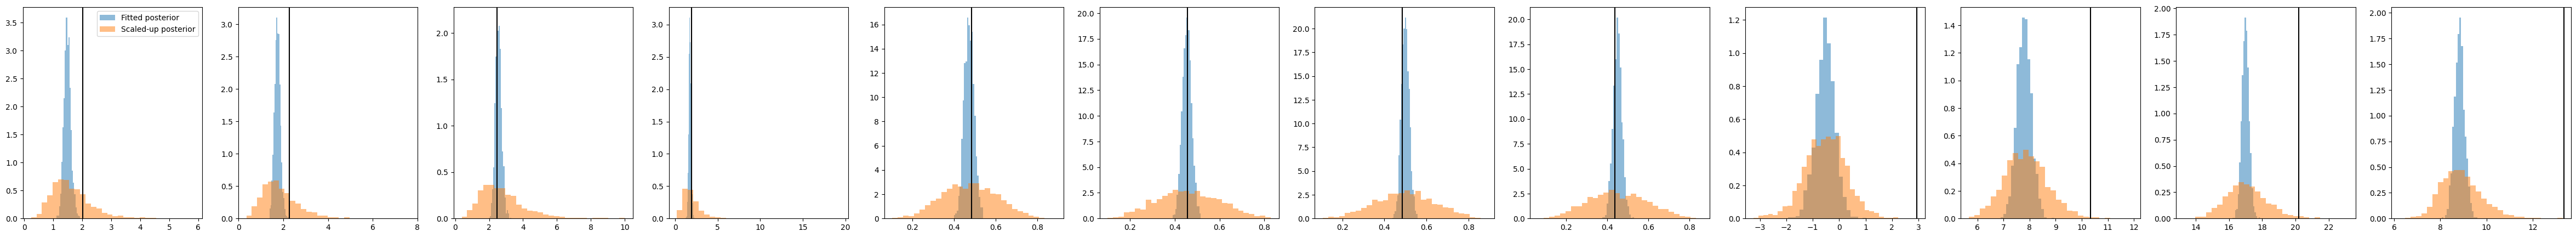

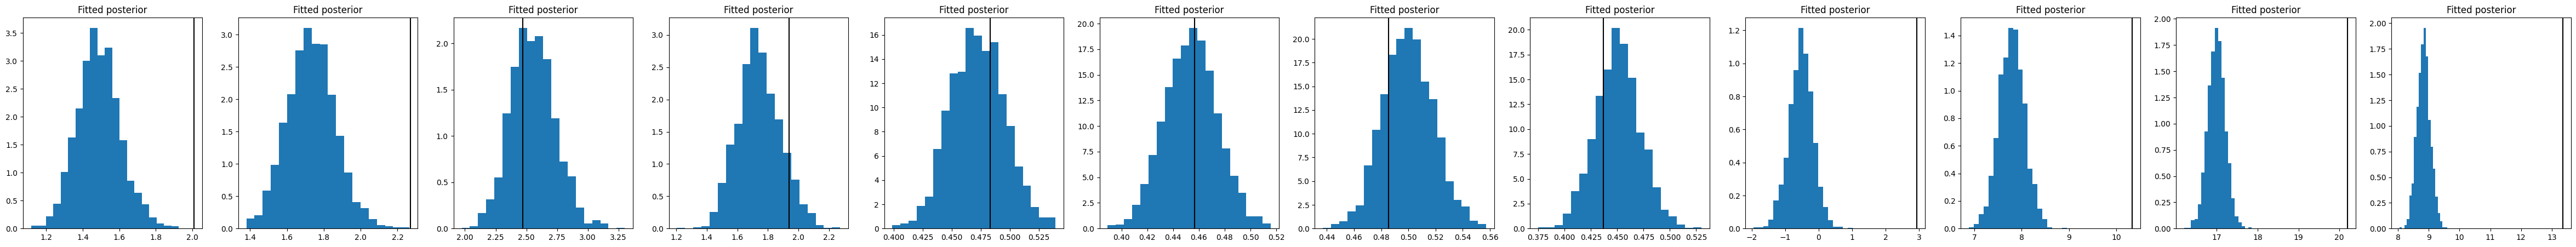

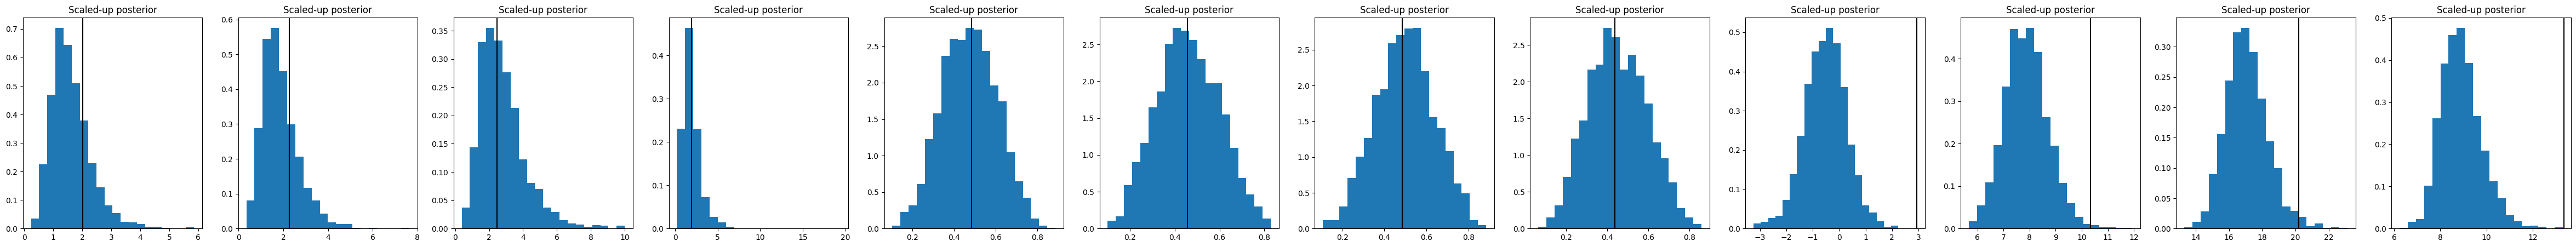

In [422]:
titles = ["Average precipitation", "Average dry days", "Average temperature"]
#xlims = [[0.5, 6], [0.2, 0.7], [3., 13]]

fig, axs = plt.subplots(1, obs_stats_target.shape[0], figsize = (obs_stats_target.shape[0]*5, 5))
for i in range(obs_stats.shape[0]):
    axs[i].hist(obs_samples_from_fitted_posterior[:, i].numpy(), bins = 20, density = True, alpha = 0.5, label = "Fitted posterior")
    axs[i].hist(sbi_proposal_obs[:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Scaled-up posterior")
    #axs[i].set_xlim(*xlims[i])
    if i == 0:
        axs[i].legend(loc = "upper right")
    axs[i].axvline(obs_stats_target[i,:].flatten(), c= "black")
    #axs[i].set_title(titles[i])
plt.show()




fig, axs = plt.subplots(1, obs_stats_target.shape[0], figsize = (obs_stats_target.shape[0]*5, 5))
for i in range(obs_stats.shape[0]):
    axs[i].hist(obs_samples_from_fitted_posterior[:, i].numpy(), bins = 20, density = True)
    axs[i].axvline(obs_stats_target[i,:].flatten(), c= "black")
    axs[i].set_title("Fitted posterior")
plt.show()


fig, axs = plt.subplots(1, obs_stats_target.shape[0], figsize = (obs_stats_target.shape[0]*5, 5))
for i in range(obs_stats.shape[0]):
    axs[i].hist(sbi_proposal_obs[:, i].numpy(), bins = 20, density = True)
    axs[i].axvline(obs_stats_target[i,:].flatten(), c= "black")
    axs[i].set_title("Scaled-up posterior")
plt.show()


Alternative: also include correlations:

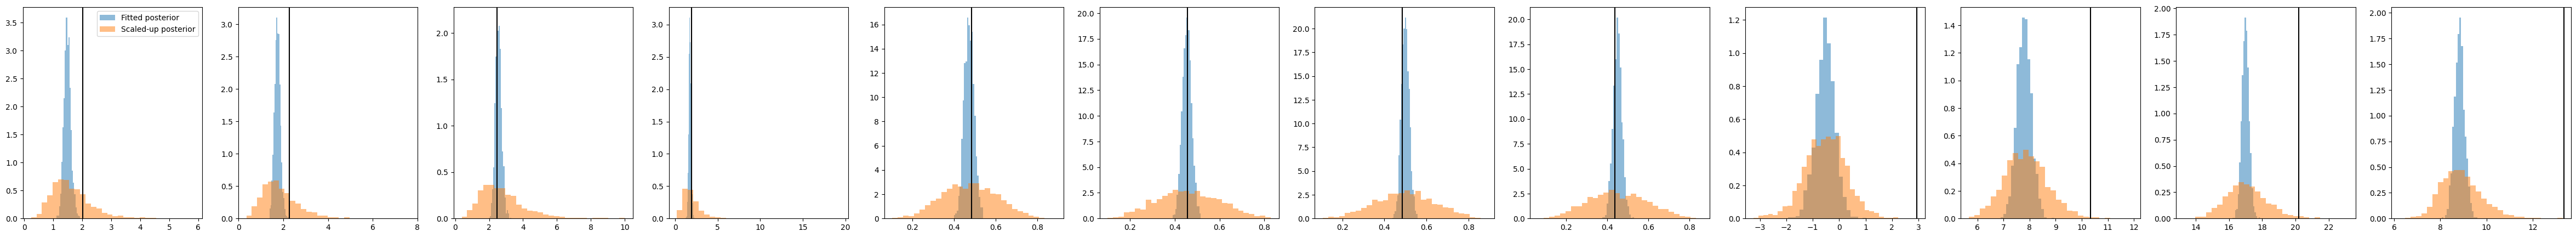

In [424]:
titles = ["Average precipitation", "Average dry days", "Average temperature"]
xlims = [[0.5, 6], [0.2, 0.7], [3., 13]]

fig, axs = plt.subplots(1, obs_stats_target.shape[0], figsize = (obs_stats_target.shape[0]*5, 5))
for i in range(obs_stats.shape[0]):
    axs[i].hist(obs_samples_from_fitted_posterior[:, i].numpy(), bins = 20, density = True, alpha = 0.5, label = "Fitted posterior")
    axs[i].hist(sbi_proposal_obs[:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Scaled-up posterior")
    #axs[i].set_xlim(*xlims[i])
    if i == 0:
        axs[i].legend(loc = "upper right")
    axs[i].axvline(obs_stats_target[i,:].flatten(), c= "black")
    #axs[i].set_title(titles[i])
plt.show()



In [458]:
sbi_alg = SNPE(sbi_proposal)
num_simulations = 1000
num_rounds = 10
proposal = sbi_proposal
for i in range(num_rounds):
    theta, x = simulate_for_sbi(wgen_sbi, proposal=proposal, num_simulations=num_simulations, simulation_batch_size=500)
    sbi_alg.append_simulations(theta, x, proposal, exclude_invalid_x=True)
    density_estimator = sbi_alg.train()
    sbi_posterior = sbi_alg.build_posterior(density_estimator).set_default_x(j2t(obs_stats_target.squeeze()))
    proposal = sbi_posterior

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:28<00:00, 11.34it/s]


 Neural network successfully converged after 81 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:21<00:00, 12.21it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 47 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:20<00:00, 12.48it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 40 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:14<00:00, 13.38it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:12<00:00, 13.77it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 36 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:12<00:00, 13.75it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:20<00:00, 12.40it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 48 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:14<00:00, 13.46it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 71 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:17<00:00, 12.88it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 45 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:18<00:00, 12.69it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

In [459]:
sbi_posterior.log_prob

<bound method DirectPosterior.log_prob of DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>>

Drawing 2000 posterior samples: 100%|██████████| 2000/2000 [00:03<00:00, 642.22it/s]


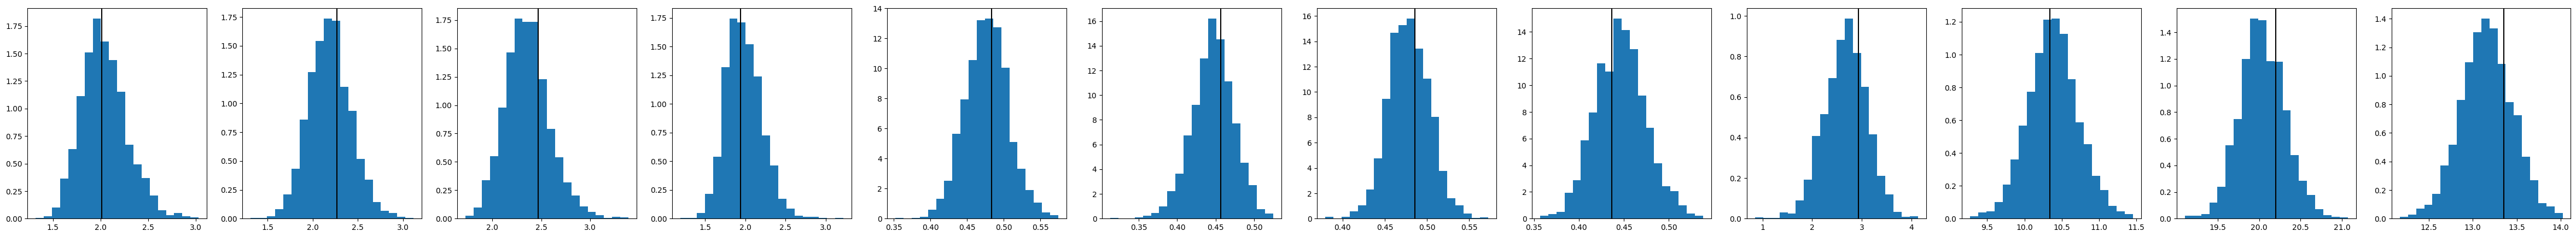

In [460]:
samples = sbi_posterior.sample((2000,))
sbi_posterior_sims = wgen_sbi(samples)
fig, axs = plt.subplots(1, obs_stats_target.shape[0], figsize = (obs_stats_target.shape[0]*5, 5))
for i in range(obs_stats.shape[0]):
    axs[i].hist(sbi_posterior_sims[:, i].numpy(), bins = 20, density = True)
    axs[i].axvline(obs_stats_target[i,:].flatten(), c= "black")
    #axs[i].set_title("Posterior samples")
plt.show()



In [461]:
sbi_posterior_sims.shape

torch.Size([2000, 12])

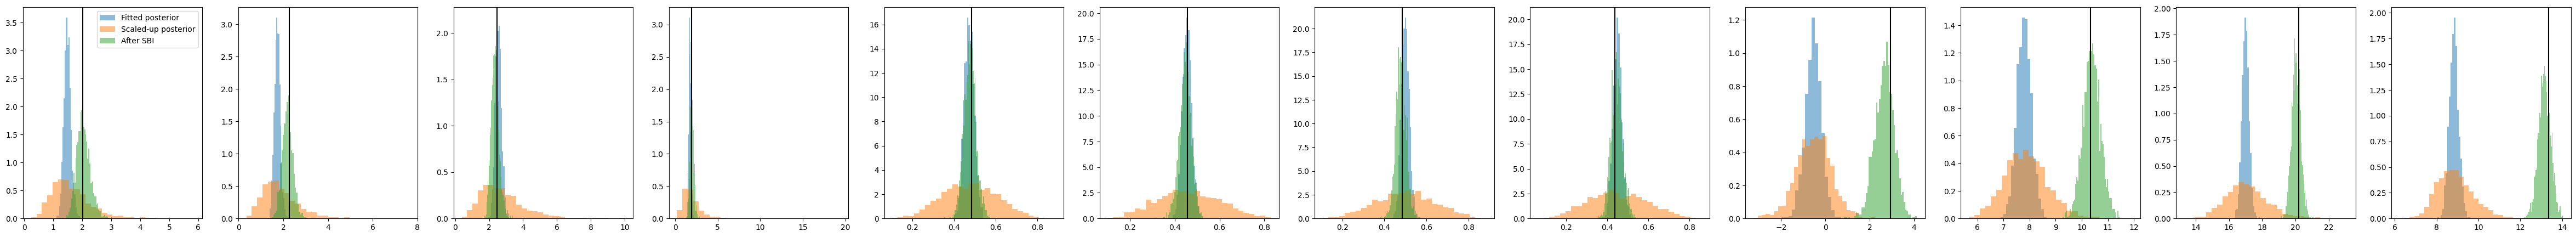

In [463]:
titles = ["Average precipitation", "Average dry days", "Average temperature"]
xlims = [[0.5, 6], [0.2, 0.7], [3., 13]]

fig, axs = plt.subplots(1, obs_stats_target.shape[0], figsize = (obs_stats_target.shape[0]*5, 5))
for i in range(obs_stats.shape[0]):
    axs[i].hist(obs_samples_from_fitted_posterior[:, i].numpy(), bins = 20, density = True, alpha = 0.5, label = "Fitted posterior")
    axs[i].hist(sbi_proposal_obs[:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Scaled-up posterior")
    if i != 1:
        axs[i].hist(sbi_posterior_sims[:, i].numpy(), bins = 50, density = True, alpha = 0.5, label = "After SBI")
    else:
        axs[i].hist(sbi_posterior_sims[:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "After SBI")
    #axs[i].set_xlim(*xlims[i])
    if i == 0:
        axs[i].legend(loc = "upper right")
    axs[i].axvline(obs_stats_target[i,:].flatten(), c= "black")
    #axs[i].set_title(titles[i])
plt.show()



In [464]:
samples

tensor([[-0.1822,  0.9736, -0.8452,  ..., -0.2734,  0.0375,  1.8366],
        [-0.1774,  0.9764, -0.7050,  ..., -0.2095,  0.0366,  1.8318],
        [-0.1620,  0.9744, -0.7036,  ..., -0.2566,  0.0361,  1.8764],
        ...,
        [-0.1707,  0.9741, -0.8975,  ..., -0.2390,  0.0350,  1.8493],
        [-0.1820,  0.9740, -0.8705,  ..., -0.2409,  0.0360,  1.8275],
        [-0.1795,  0.9703, -0.8707,  ..., -0.2443,  0.0350,  1.8466]])

In [465]:
diff = sbi_posterior_sims-j2t(obs_stats_target).swapaxes(-1, -2)
diff = torch.norm(diff / sbi_posterior_sims.std(dim = 1).unsqueeze(1), dim = 1)
min_diff_idx = torch.argmin(diff)
sbi_posterior_min_diff_sims = wgen_sbi(samples[min_diff_idx, :].unsqueeze(0).expand(2000, -1))

In [466]:
sbi_posterior_median_sims = wgen_sbi(samples.median(0)[0].unsqueeze(0).expand(2000, -1))

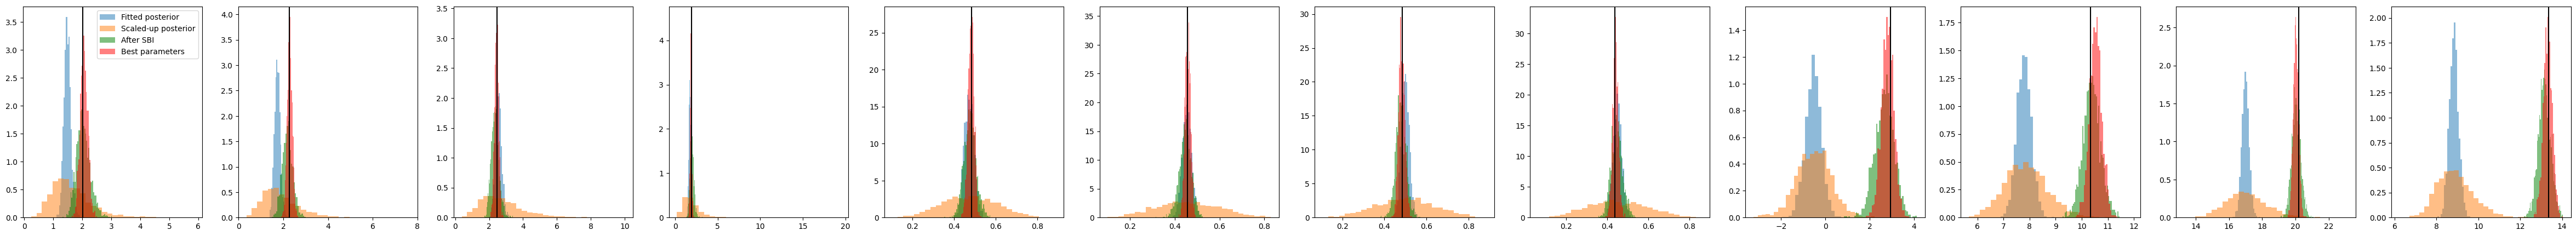

In [484]:

titles = ["Average precipitation", "Average dry days", "Average temperature"]
xlims = [[0.5, 6], [0.2, 0.7], [3., 13]]

fig, axs = plt.subplots(1, obs_stats_target.shape[0], figsize = (obs_stats_target.shape[0]*5, 5))
for i in range(obs_stats.shape[0]):
    axs[i].hist(obs_samples_from_fitted_posterior[:, i].numpy(), bins = 20, density = True, alpha = 0.5, label = "Fitted posterior")
    axs[i].hist(sbi_proposal_obs[:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Scaled-up posterior")
    if i != 1:
        axs[i].hist(sbi_posterior_sims[:, i].numpy(), bins = 50, density = True, alpha = 0.5, label = "After SBI", color = "green")
    else:
        axs[i].hist(sbi_posterior_sims[:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "After SBI", color = "green")
    #axs[i].hist(sbi_posterior_median_sims[:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Mean")
    axs[i].hist(sbi_posterior_min_diff_sims[:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Best parameters", color = "red")

    #axs[i].set_xlim(*xlims[i])
    if i == 0:
        axs[i].legend(loc = "upper right")
    axs[i].axvline(obs_stats_target[i,:].flatten(), c= "black")
    #axs[i].set_title(titles[i])
plt.show()



In [485]:
simulator_get_rain, _ = wgen.simulator(rng_seed=1234)
simulator_get_rain = jax2torch(simulator_get_rain)

theta = j2t(svi_posterior.mean).unsqueeze(0)
hist_samples = simulator_get_rain(theta)

theta_adj = samples[min_diff_idx, :].unsqueeze(0)
#theta_adj = samples.median(0)[0].unsqueeze(0)
#theta_adj = samples.mean(0).unsqueeze(0)
fut_samples = simulator_get_rain(theta_adj)

In [486]:
rain_fut = fut_samples[0, :, 0]
rain_hist = hist_samples[0, :, 0]
rain_obs = obs["prec"].flatten()

tavg_fut = fut_samples[0, :, 2]
tavg_hist = hist_samples[0, :, 2]
tavg_obs = obs["prec"].flatten()

In [524]:
rai

(11323,)

In [510]:
case_study_2(jnp.expand_dims(wgen.timestamps[0,:,:], 0), t2j(rain_hist), None, t2j(tavg_hist), None)

Array([[ 1.9259524 ,  7.170557  ,  0.35675663, ...,  2.6167867 ,
         0.        ,  0.        ],
       [ 1.9259524 ,  7.170556  ,  0.3567567 , ...,  2.616787  ,
         0.        ,  0.        ],
       [ 1.9259524 ,  7.170555  ,  0.3567567 , ...,  2.6167872 ,
         0.        ,  0.        ],
       ...,
       [ 2.872485  ,  2.4393308 ,  2.4629827 , ..., -4.912342  ,
        -8.172056  , -7.531489  ],
       [ 2.8724854 ,  2.4393308 ,  2.4629827 , ..., -4.912342  ,
        -8.172056  , -7.531489  ],
       [ 2.8724854 ,  2.4393306 ,  2.4629827 , ..., -4.912342  ,
        -8.172055  , -7.531489  ]], dtype=float32)

In [ ]:
case_study_2(None, t2j(rain_fut), None, t2j(tavg_fut), None)

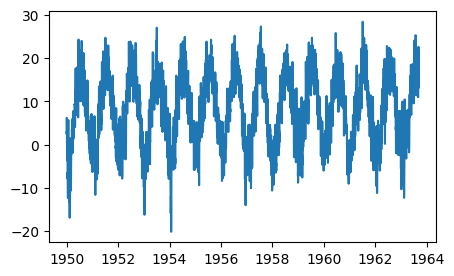

In [536]:
fig, ax = plt.subplots(1,1, figsize = (5, 3))
ax.plot(basin_data_train.index[:5000], tavg_hist[:5000], label = "Base")



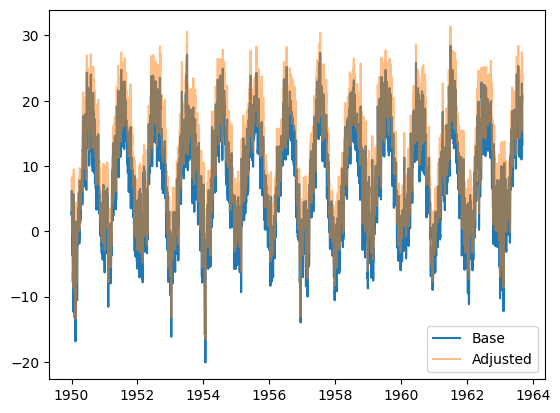

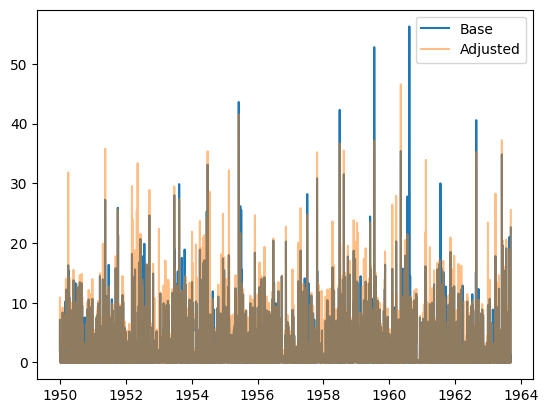

In [526]:
plt.plot(basin_data_train.index[:5000], tavg_hist[:5000], label = "Base")
plt.plot(basin_data_train.index[:5000], tavg_fut[:5000], alpha = 0.5, label = "Adjusted")
plt.legend()
plt.show()

plt.plot(basin_data_train.index[:5000], rain_hist[:5000], label = "Base")
plt.plot(basin_data_train.index[:5000], rain_fut[:5000], alpha = 0.5, label = "Adjusted")
plt.legend()

In [498]:
theta_adj = samples[min_diff_idx, :].unsqueeze(0)
fut_many_samples = simulator_get_rain(theta_adj.expand(100, -1))

In [499]:
rain_fut_many_samples = fut_many_samples[:, :, 0].unsqueeze(-1).numpy()
Tavg_fut_many_samples = fut_many_samples[:, :, 2].unsqueeze(-1).numpy()

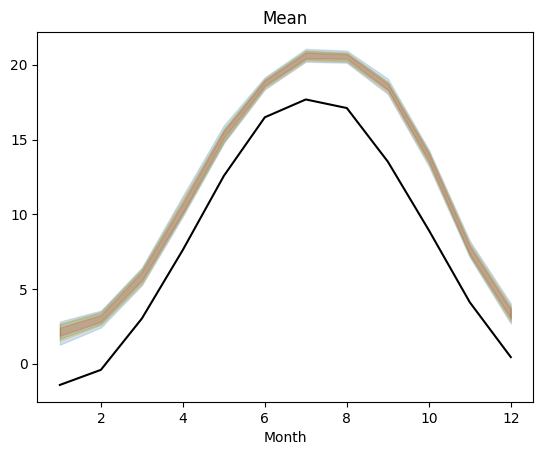

In [500]:
get_mean_plot(obs["Tavg"], Tavg_fut_many_samples, basin_data_train.index)


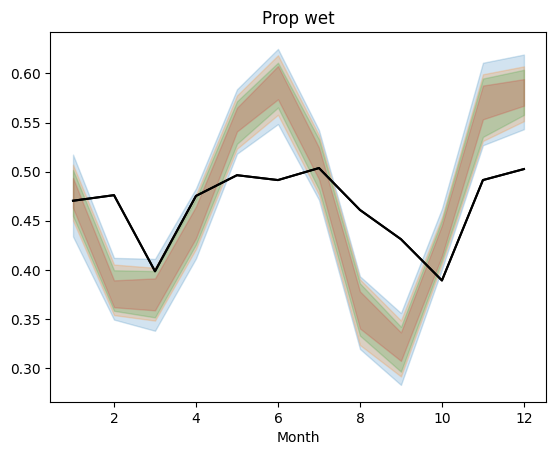

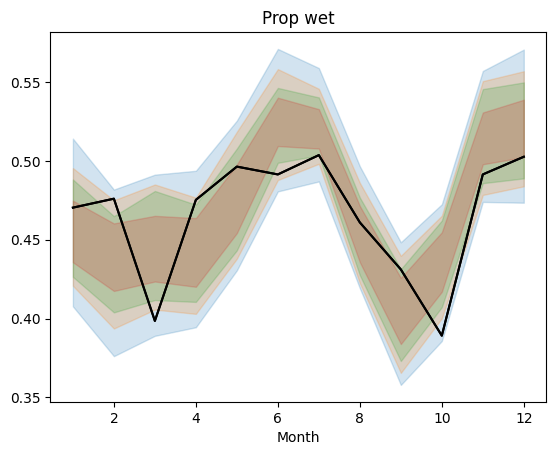

In [501]:
get_prop_wet_plot(obs["prec"], rain_fut_many_samples, basin_data_train.index)
plt.show()
get_prop_wet_plot(obs["prec"], svi_preds["prec"], basin_data_train.index)


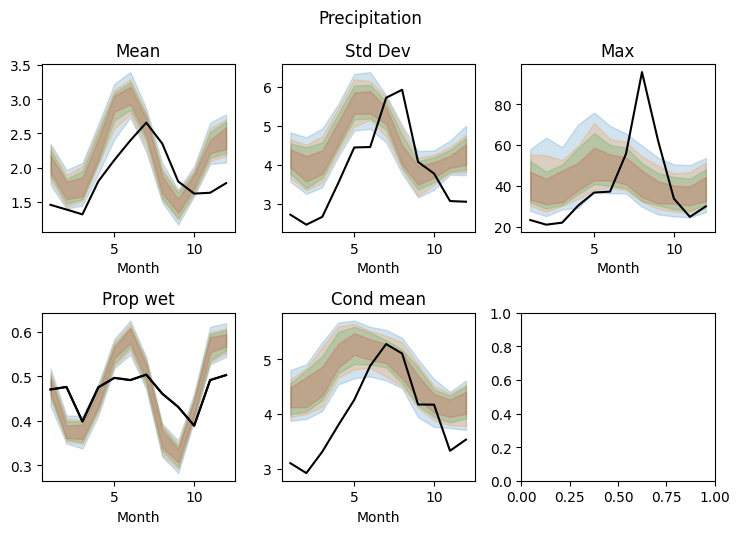

In [502]:
fig = plt.figure(layout="tight", figsize=(7.5, 7.5))
fig.suptitle("Precipitation")

gs = GridSpec(3, 3, figure=fig)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["prec"], rain_fut_many_samples, basin_data_train.index, ax=ax_row_1[0])
get_std_plot(obs["prec"], rain_fut_many_samples, basin_data_train.index, ax=ax_row_1[1])
get_max_plot(obs["prec"], rain_fut_many_samples, basin_data_train.index, ax=ax_row_1[2])

# Row 2
ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_prop_wet_plot(obs["prec"], rain_fut_many_samples, basin_data_train.index, ax=ax_row_2[0])
get_cond_mean_plot(obs["prec"], rain_fut_many_samples, basin_data_train.index, ax=ax_row_2[1])


In [563]:
def run_sbi(wgen, svi_result, observable_fct, obs_target, scale_factor = 2.5, parameter_mask = None, num_samples = 2000, num_rounds = 10):
    """
    Run SBI on a weather generator to calibrate it to a set of target statistics.

    Args:
        wgen: A WGEN object including a weather generator.
        svi_result: The result of an SVI fit through wgen.fit.
        observable_fct: A function taking as input arrays of realizations of ts, precip, Tmin, Tavg, Tmax and outputting summary statistics.
        obs_target: A vector of target summary statistics.
        scale_factor: Scaling amount for the posterior to obtain the SBI prior.
        parameter_mask: A mask to keep certain parameters from being scaled up. Helps with the SBI fit.
        
    Returns:
        tuple[array,array | None]: outputs, observable

    """
    sim, sim_prior = wgen.simulator(observable=observable_fct, rng_seed=1234) # Generate simulator and prior
    wgen_sbi = jax2torch(sim) # Convert to torch for sbi

    print("Sampling...")

    fitted_posterior = guide.get_posterior(svi_result.params)

    # Sample from mean of fitted posterior
    summary_stats_samples_from_mean_fitted_posterior = wgen_sbi(j2t(fitted_posterior.mean).unsqueeze(0).expand(2000, -1))

    # Sample from fitted posterior
    proposal_fitted_posterior = torch.distributions.MultivariateNormal(j2t(fitted_posterior.mean), j2t(fitted_posterior.covariance_matrix))
    samples_from_fitted_posterior = proposal_fitted_posterior.sample((num_samples,))
    summary_stats_samples_from_fitted_posterior = wgen_sbi(samples_from_fitted_posterior)

    # Sample from scaled up posterior (proposal for SBI)
    if parameter_mask is None:
        parameter_mask = 1.
    sbi_proposal = torch.distributions.MultivariateNormal(j2t(fitted_posterior.mean), j2t(jnp.diag(fitted_posterior.covariance_matrix)*jnp.eye(len(fitted_posterior.mean)) + parameter_mask*(scale_factor**2 - 1)*jnp.eye(len(fitted_posterior.mean))* jnp.diag(fitted_posterior.covariance_matrix)))
    samples_from_sbi_proposal = sbi_proposal.sample((2000,))
    summary_stats_samples_from_sbi_proposal = wgen_sbi(samples_from_sbi_proposal)

    # Plot fitted posterior and SBI proposal as well as targets
    fig, axs = plt.subplots(1, obs_stats_target.shape[0], figsize = (obs_stats_target.shape[0]*5, 5))
    for i in range(obs_stats.shape[0]):
        axs[i].hist(summary_stats_samples_from_fitted_posterior[:, i].numpy(), bins = 20, density = True, alpha = 0.5, label = "Fitted posterior")
        axs[i].hist(summary_stats_samples_from_sbi_proposal[:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Scaled-up posterior")
        axs[i].legend(loc = "upper right")
        axs[i].axvline(obs_stats_target[i,:].flatten(), c= "black")
    plt.show()

    # Run SBI
    sbi_alg = SNPE(sbi_proposal)
    num_simulations = 1000
    proposal = sbi_proposal
    for i in range(num_rounds):
        theta, x = simulate_for_sbi(wgen_sbi, proposal=proposal, num_simulations=num_simulations, simulation_batch_size=500)
        sbi_alg.append_simulations(theta, x, proposal, exclude_invalid_x=True)
        density_estimator = sbi_alg.train()
        sbi_posterior = sbi_alg.build_posterior(density_estimator).set_default_x(j2t(obs_stats_target.squeeze()))
        proposal = sbi_posterior


    # Sample from SBI posterior
    samples_from_sbi_posterior = sbi_posterior.sample((2000,))
    summary_stats_samples_from_sbi_posterior = wgen_sbi(samples)

    # Plot
    fig, axs = plt.subplots(1, obs_stats_target.shape[0], figsize = (obs_stats_target.shape[0]*5, 5))
    for i in range(obs_stats.shape[0]):
        axs[i].hist(summary_stats_samples_from_fitted_posterior[:, i].numpy(), bins = 20, density = True, alpha = 0.5, label = "Fitted posterior")
        axs[i].hist(summary_stats_samples_from_sbi_proposal[:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Scaled-up posterior")
        axs[i].hist(summary_stats_samples_from_sbi_posterior[:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "After SBI")
        axs[i].legend(loc = "upper right")
        axs[i].axvline(obs_stats_target[i,:].flatten(), c= "black")
    plt.show()

    # Get point estimate 
    diff = obs_samples_from_sbi_posterior-j2t(obs_stats_target).swapaxes(-1, -2)
    diff = torch.norm(diff / obs_samples_from_sbi_posterior.std(dim = 1).unsqueeze(1), dim = 1)
    min_diff_parameter = samples_from_sbi_posterior[torch.argmin(diff), :]
    summary_stats_samples_from_sbi_posterior_min_diff = wgen_sbi(min_diff_parameter.unsqueeze(0).expand(2000, -1))

    # Dict to return
    samples_summary_stats = {
        "mean_fitted_posterior": summary_stats_samples_from_mean_fitted_posterior,
        "fitted_posterior": summary_stats_samples_from_fitted_posterior, 
        "sbi_proposal": summary_stats_samples_from_sbi_proposal,
        "sbi_posterior": summary_stats_samples_from_sbi_posterior,
        "sbi_posterior_point_estimate": summary_stats_samples_from_sbi_posterior_min_diff
    }

    # Get realizations from weather generator
    simulator_get_obs, _ = wgen.simulator(rng_seed=1234)
    simulator_get_obs = jax2torch(simulator_get_obs)
    
    samples_obs = {
        "mean_fitted_posterior": simulator_get_obs(j2t(fitted_posterior.mean).unsqueeze(0).expand(100, -1)),
        "fitted_posterior": simulator_get_obs(proposal_fitted_posterior.sample((100,))),
        "sbi_posterior": simutor_get_obs(sbi_posterior.sample((100,))),
        "sbi_posterior_point_estimate": simulator_get_obs(min_diff_parameter.unsqueeze(0).expand(100, -1))
    }

    return sbi_posterior, samples_summary_stats, samples_obs


In [ ]:
# Get parameter mask of parameters to ignore
posterior_sampler = Predictive(guide, params=svi_result.params, num_samples=100)
posterior_params = posterior_sampler(prng)

posterior_params_without_auto_latent = {k: e for k, e in posterior_params.items() if k != "_auto_latent"}
ignore_list = [n for n in posterior_params_without_auto_latent.keys() if "Trange" in n or "Tskew" in n]# or "precip_occ" in n]
parameter_mask = np.concatenate([np.ones_like(v.mean(axis=0)) if k in ignore_list else np.zeros_like(v.mean(axis=0)) for k,v in posterior_params_without_auto_latent.items()])
parameter_mask = jnp.array(parameter_mask)

sbi_posterior, samples_summary_stats, samples_obs = run_sbi(wgen, svi_result, observable_fct, obs_target, scale_factor = 2.5, parameter_mask = None, num_samples = 2000, num_rounds = 10):


Overview plots:

In [ ]:
theta_adj = samples.median(0)[0].unsqueeze(0)
rain_samples_adj = simulator_get_rain(torch.concat(100*[theta_adj], axis = 0))

In [487]:
future_obs = {"prec": rain_samples_adj[:, :, 0], "Tmin": rain_samples_adj[:, :, 1], "Tavg": rain_samples_adj[:, :, 2], "Tmax": rain_samples_adj[:, :, 3], "Trange": rain_samples_adj[:, :, 3] - rain_samples_adj[:, :, 1]}
future_obs["Tskew"] = (future_obs["Tavg"] - future_obs["Tmin"])/future_obs["Trange"]
future_obs = {k: np.expand_dims(e, -1) for k, e in future_obs.items()}

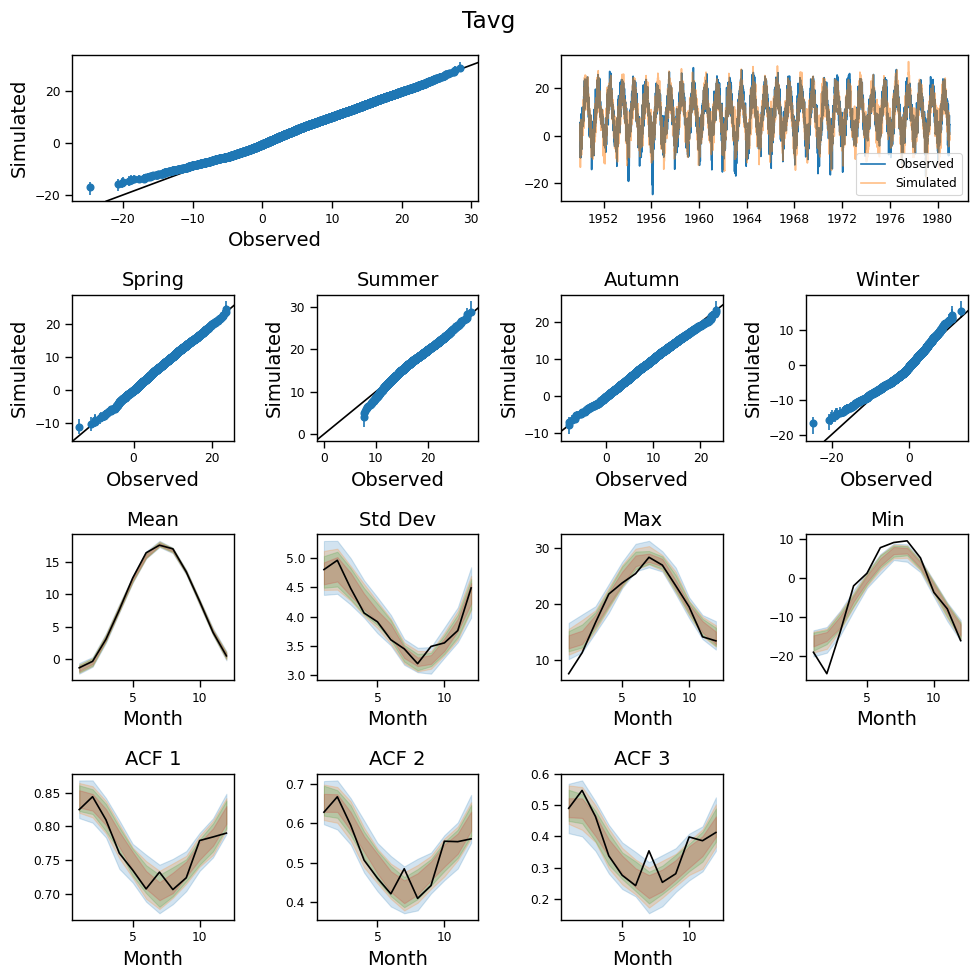

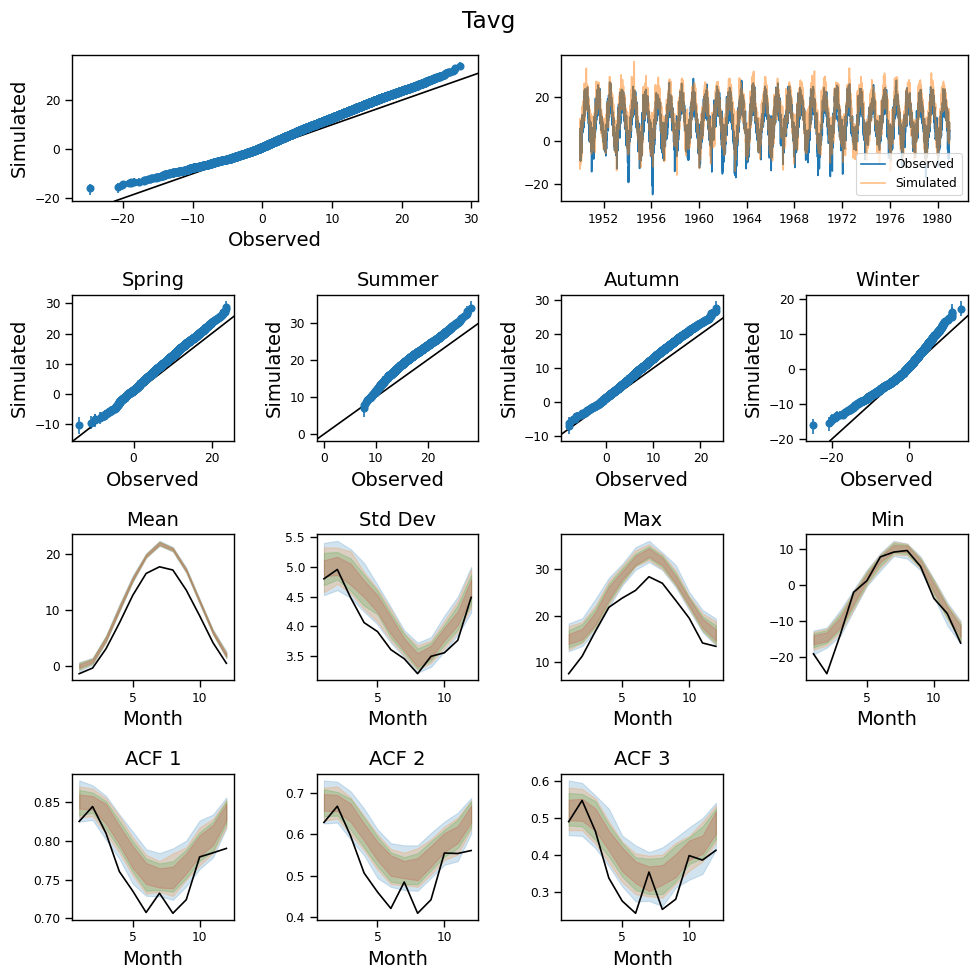

In [489]:
Tavg_overview(obs, svi_preds, basin_data_train)
Tavg_overview(obs, future_obs, basin_data_train)

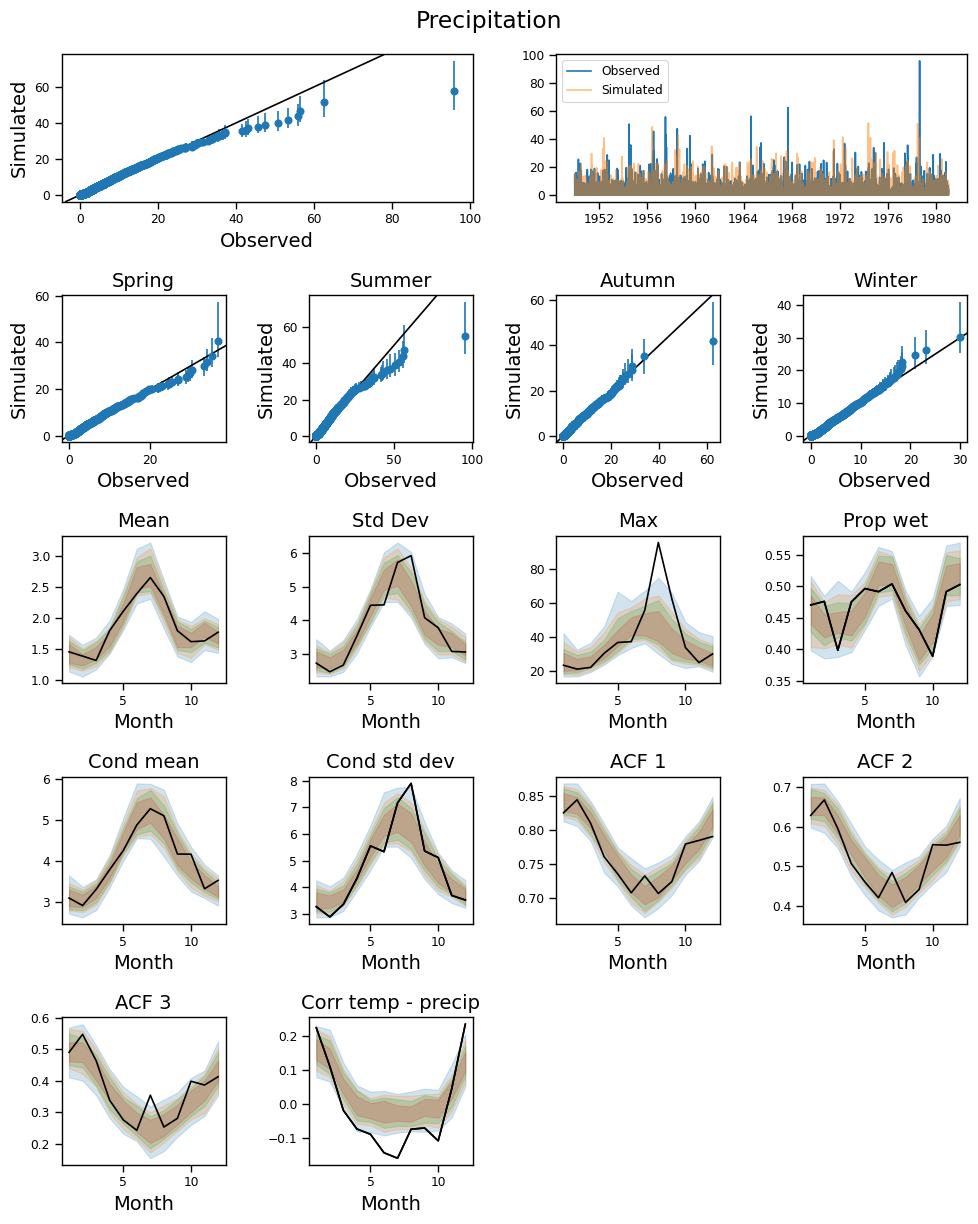

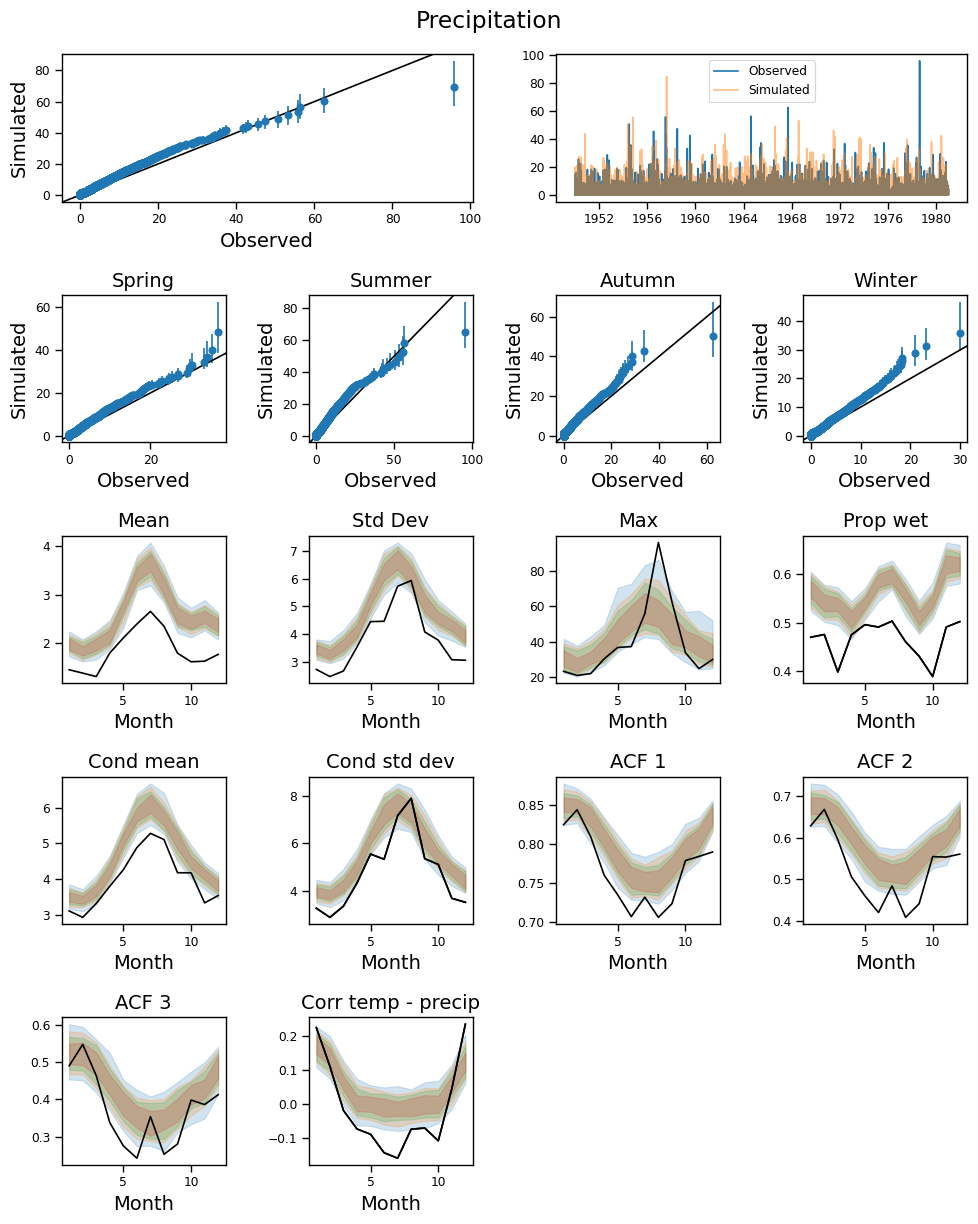

In [491]:
prec_overview(obs, svi_preds, basin_data_train)
prec_overview(obs, future_obs, basin_data_train)

In [197]:
print(f"Cond mean hist {rain_hist[rain_hist > 0].mean()}, cond mean fut: {rain_fut[rain_fut > 0].mean()}")

Cond mean hist 4.085076808929443, cond mean fut: 3.912468194961548


In [80]:
import seaborn as sns

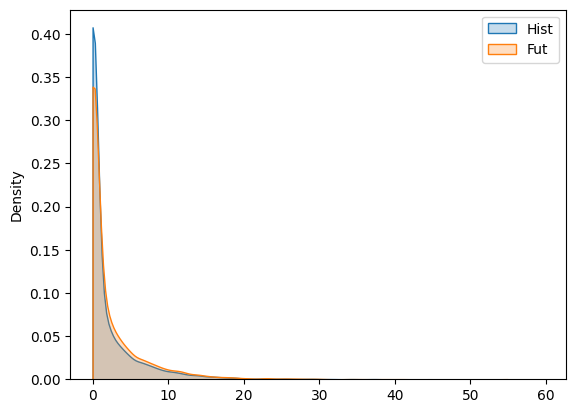

In [341]:
sns.kdeplot(rain_hist, cut = 0, fill = True, label = "Hist")
sns.kdeplot(rain_fut, cut = 0, fill = True, label = "Fut")
plt.legend()

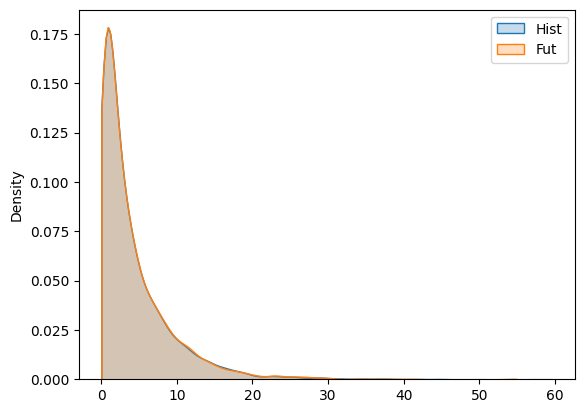

In [343]:
sns.kdeplot(rain_hist[rain_hist > 0], cut = 0, fill = True, label = "Hist")
sns.kdeplot(rain_fut[rain_fut > 0], cut = 0, fill = True, label = "Fut")
plt.legend()

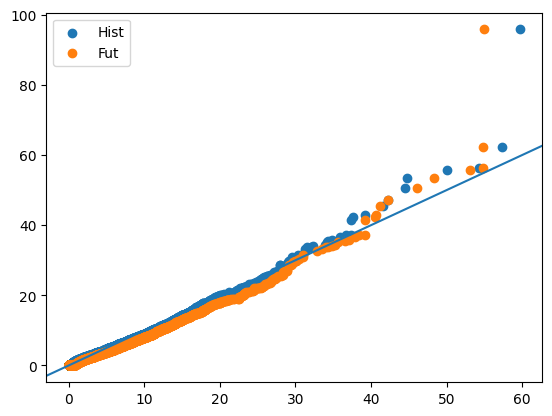

In [345]:
plt.scatter(np.sort(rain_hist), np.sort(rain_obs), label = "Hist")
plt.scatter(np.sort(rain_fut), np.sort(rain_obs), label = "Fut")
plt.axline((0,0), slope = 1)
plt.legend()

## Other

In [378]:
def precip_summary_stats(pr, cdd_thresh=0.0, axis=0):
    pmean = jnp.mean(pr, axis=axis)
    p95 = jnp.nanquantile(jnp.where(pr > 0, pr, jnp.nan), 0.95, axis=axis)
    rp95 = jnp.nanmean(jnp.where(pr > p95, pr, jnp.nan), axis=axis)
    fwd = jnp.mean(pr > 0, axis=axis)
    cdd = wx.utils.cumulative_dry_days(pr, threshold=cdd_thresh, axis=axis)
    return jnp.stack([pmean, rp95, fwd, cdd])

def tair_summary_stats(Tair_mean, Tair_min, Tair_max):
    Tavg = jnp.mean(Tair_mean, axis=0)
    Trange = jnp.mean(Tair_max - Tair_min, axis=0)
    Tskew = jnp.mean((Tair_mean - Tair_min) / (Tair_max - Tair_min), axis=0)
    ftd = jnp.mean(jnp.where(Tair_mean > 0, 1, 0), axis=0)
    # ffd = jnp.mean(jnp.where(Tair_mean <= 0, 1, 0), axis=0)
    return jnp.stack([Tavg, Trange, Tskew, ftd])

def wgen_summary_stats(ts, precip, Tmin, Tavg, Tmax):
    precip_stats = precip_summary_stats(precip)
    Tair_stats = tair_summary_stats(Tavg, Tmin, Tmax)
    return jnp.concat([precip_stats, Tair_stats], axis=0)
    # return precip_stats

summary_stat_names = ["prec_mean", "rp95", "norm wet days", "mean dry spell length", "Tair_mean", "Tair_range", "Tair_skew", "norm thaw days"]

In [379]:
wgen_sim, wgen_prior = wgen.simulator(observable=wgen_summary_stats, rng_seed=1234)

In [380]:
sim_stats = wgen_sim(wgen_prior.sample(jax.random.PRNGKey(0), (10,)))
sim_stats.shape

(10, 8)

In [381]:
obs['Tmin'] = obs['Tavg'] - obs['Tskew']*obs['Trange']
obs['Tmax'] = obs['Tmin'] + obs['Trange']
obs_stats = wgen_summary_stats(wgen.timestamps[0,:,:], obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats

Array([[ 1.8636943 ],
       [20.212057  ],
       [ 0.4654244 ],
       [ 3.2772062 ],
       [ 8.347303  ],
       [ 7.7874007 ],
       [ 0.47035772],
       [ 0.84827346]], dtype=float32)

We can use the "true" prior of the model by wrapping it in a `torch` distribution as such:

    wx.distributions.NumPyro2TorchDistribution(wgen_prior)

However, the true prior for the GLM-type models is very uninformative and will generate many physically implausible or simply invalid simulations.

The two options here are therefore:

1. Design a better prior
2. Use the SVI calibrated posterior to construct a "better" prior for SBI

The more prinicpled option is (1), but it's also hard and time consuming. So we go with (2) instead :)


In [383]:
wgen_sbi = jax2torch(wgen_sim)
# wgen_sbi_prior = process_prior(wx.distributions.NumPyro2TorchDistribution(wgen_prior))


In [384]:
svi_posterior = guide.get_posterior(svi_result.params)
svi_posterior_torch = torch.distributions.MultivariateNormal(j2t(svi_posterior.mean), j2t(svi_posterior.covariance_matrix))
scale_factor = 2
svi_proposal = torch.distributions.MultivariateNormal(j2t(svi_posterior.mean), j2t(scale_factor**2*jnp.eye(len(svi_posterior.mean))*jnp.diag(svi_posterior.covariance_matrix)))
# svi_proposal = torch.distributions.MultivariateNormal(j2t(svi_posterior.mean), j2t(scale_factor**2*jnp.eye(len(svi_posterior.mean))*svi_posterior.covariance_matrix))

# sample from propsoal prior and run simulations
sbi_prior_samples = svi_proposal.sample((100,))
sbi_prior_obs = wgen_sbi(sbi_prior_samples)

In [385]:

# sample from SVI posterior
svi_posterior_samples = svi_posterior_torch.sample((200,))
svi_posterior_sims = wgen_sbi(svi_posterior_samples)

In [386]:
# sample from variance-inflated proposal
svi_prposoal_samples = svi_proposal.sample((200,))
svi_proposal_sims = wgen_sbi(svi_prposoal_samples)

In [387]:
posterior_sims = pd.DataFrame(svi_posterior_sims.numpy(), columns=summary_stat_names)
proposal_sims = pd.DataFrame(svi_proposal_sims.numpy(), columns=summary_stat_names)

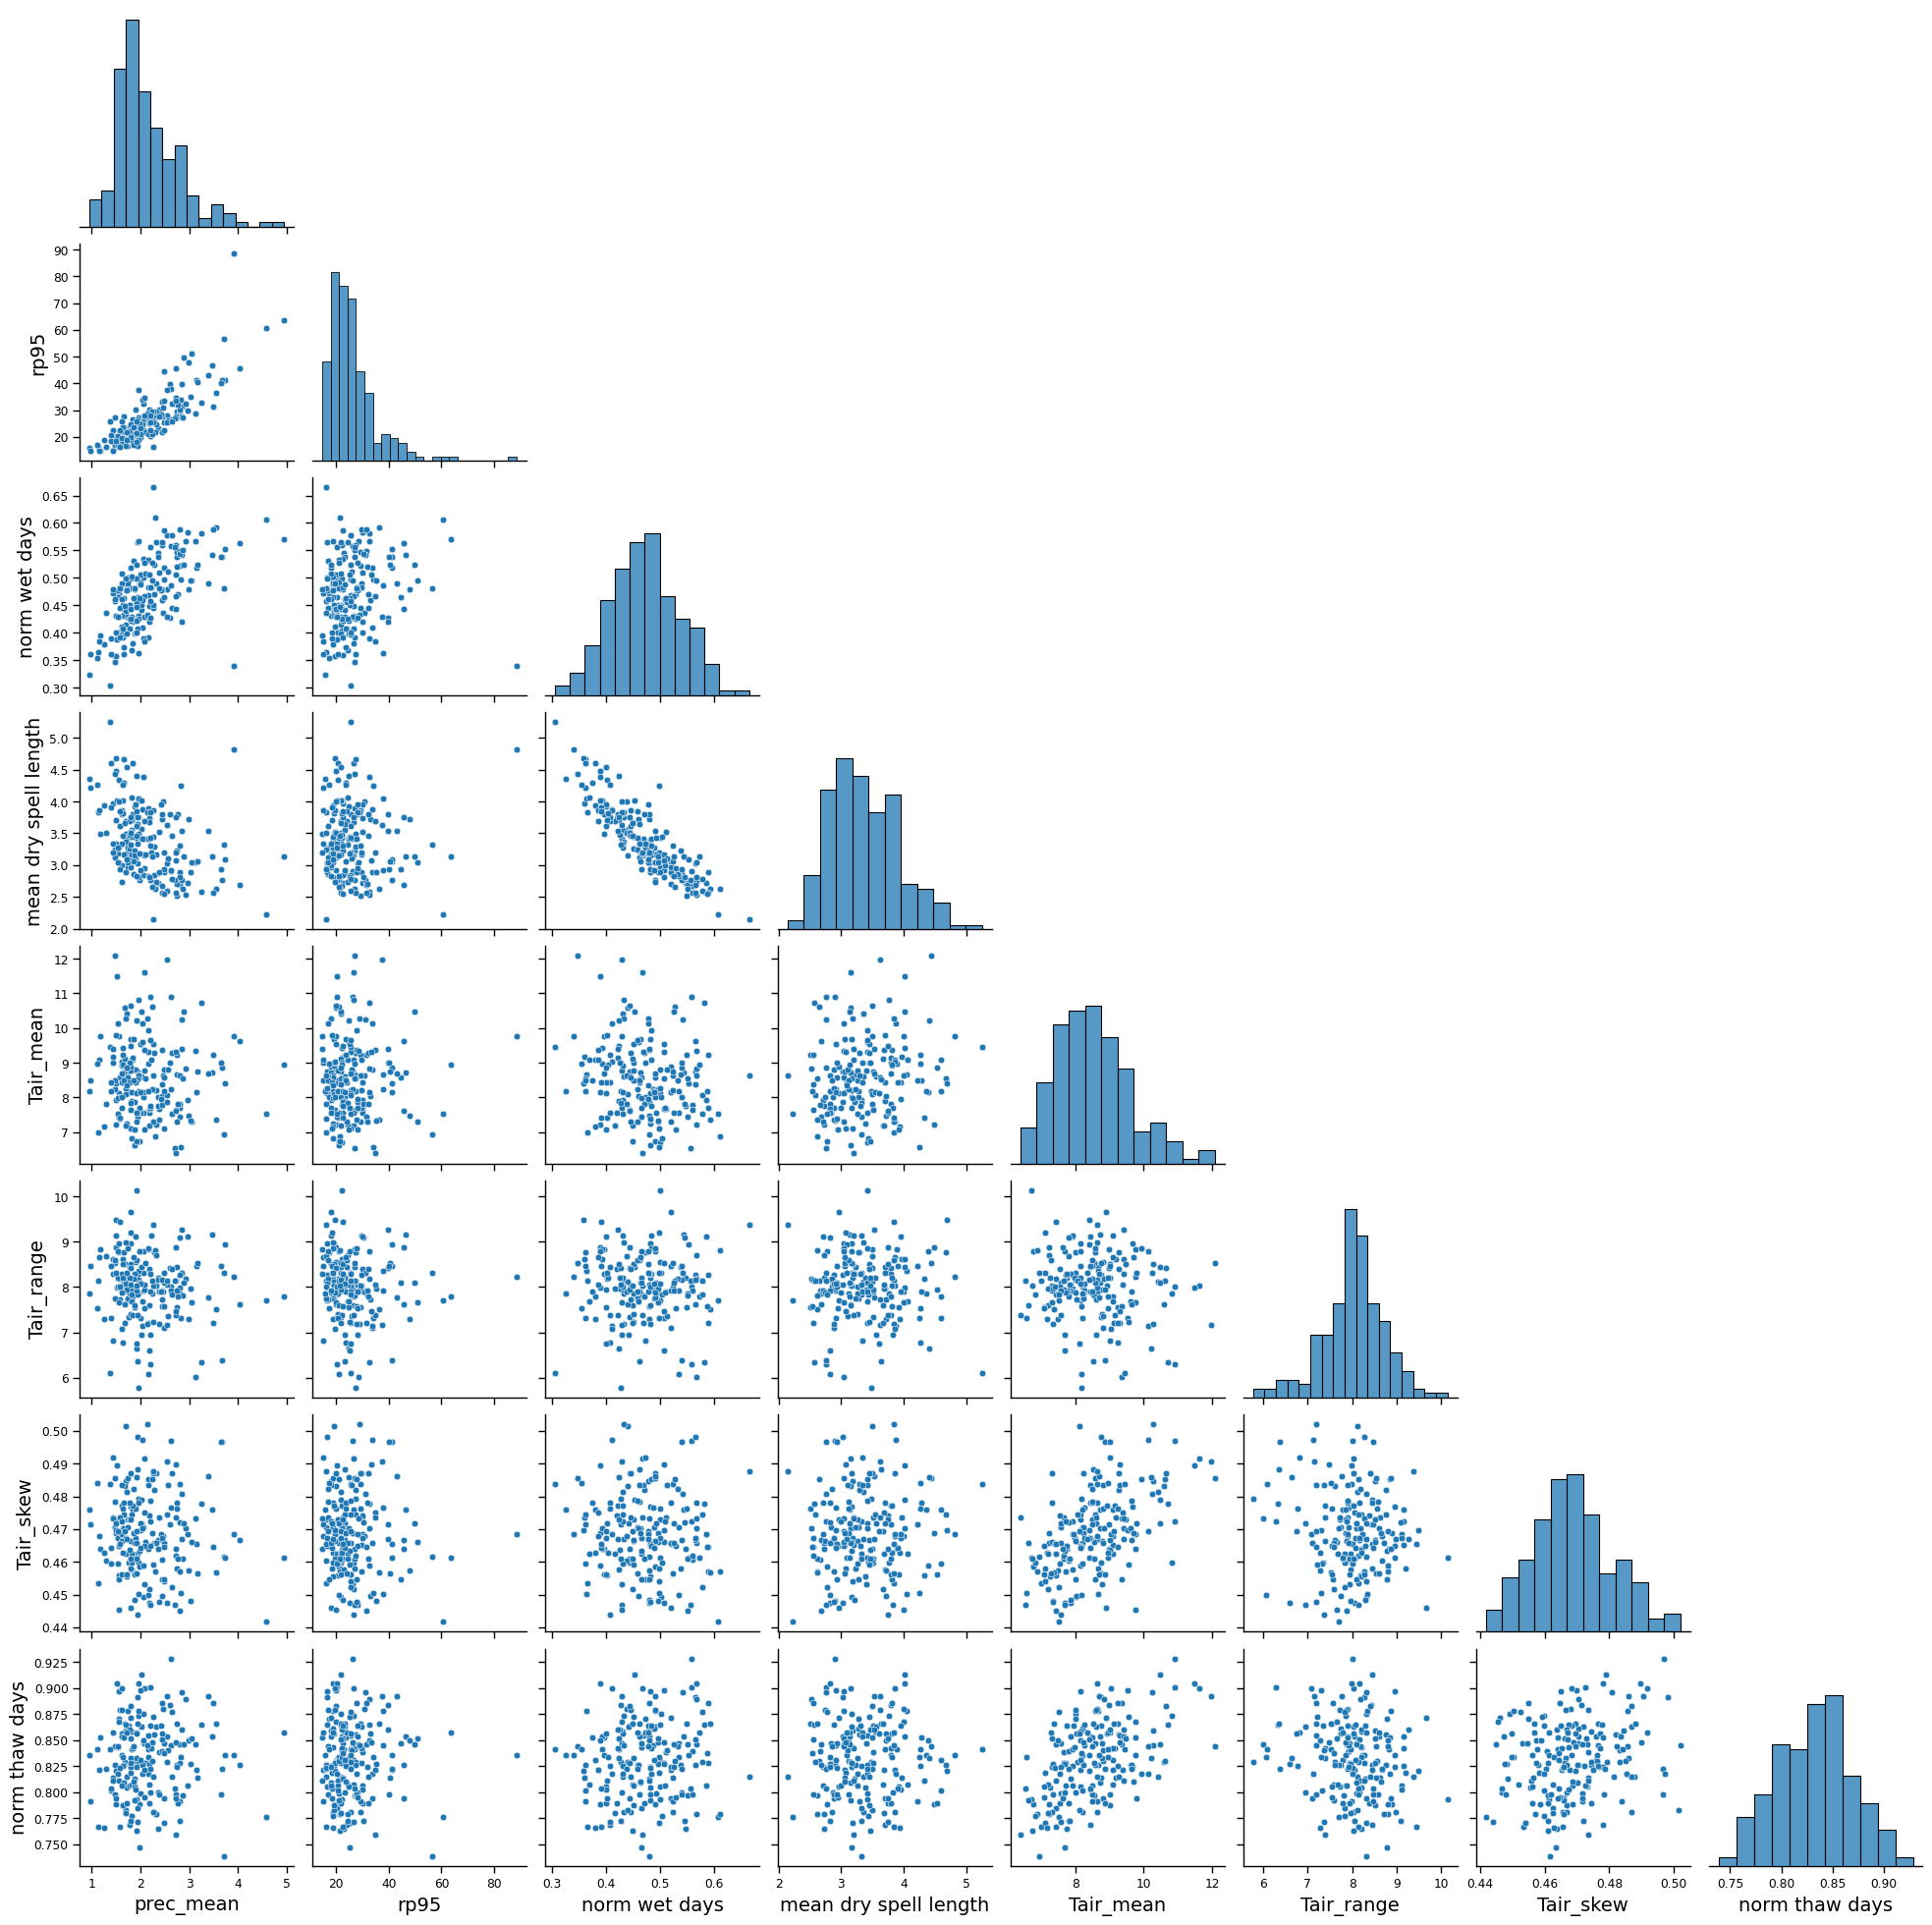

In [389]:
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":14})
sns.pairplot(proposal_sims.dropna(), corner=True)
#plt.savefig("../plots/wgen_summary_stats_corner_plot.png")

In [46]:
# compute empirical mean and covariance, dropping rows with nan values
svi_posterior_sims_mean = torch.mean(svi_posterior_sims[torch.isfinite(svi_posterior_sims).all(dim=1),:], dim=0)
svi_proposal_sims_mean = torch.mean(svi_proposal_sims[torch.isfinite(svi_proposal_sims).all(dim=1),:], dim=0)
svi_posterior_sims_cov = torch.cov(svi_posterior_sims[torch.isfinite(svi_posterior_sims).all(dim=1),:].T)
svi_proposal_sims_cov = torch.cov(svi_proposal_sims[torch.isfinite(svi_proposal_sims).all(dim=1),:].T)

<Axes: >

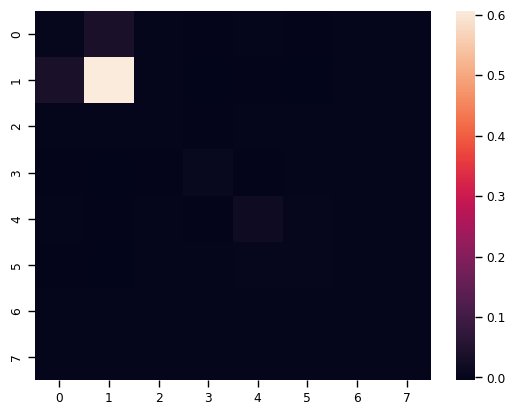

In [47]:
sns.heatmap(svi_posterior_sims_cov.numpy())

<Axes: >

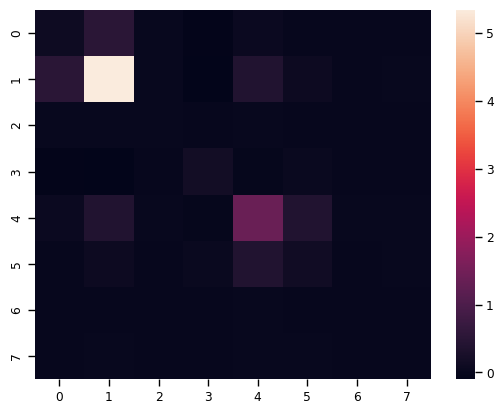

In [48]:
sns.heatmap(svi_proposal_sims_cov.numpy())

In [49]:
proposal_sims_dist = torch.distributions.MultivariateNormal(svi_proposal_sims_mean, svi_proposal_sims_cov)
obs_stats2 = t2j(proposal_sims_dist.sample((1,)).T)
obs_stats2 - obs_stats

Array([[-2.0868897e-01],
       [-2.3722725e+00],
       [ 1.8947244e-02],
       [-1.4467025e-01],
       [-1.0982389e+00],
       [-7.6457119e-01],
       [-5.2743554e-03],
       [ 2.3602247e-03]], dtype=float32)

In [ ]:
num_simulations = 2000
num_rounds = 1 # for some reason, single round inference seems to work much better than multi-round. might need to report this to the sbi developers?
proposal = svi_proposal
sbi_alg = SNPE(proposal)
# sbi_alg = SNLE(proposal)

In [ ]:
for i in range(num_rounds):
    print(f"Starting SBI round {i+1}/{num_rounds}")
    theta, x = simulate_for_sbi(wgen_sbi, proposal=proposal, num_simulations=num_simulations, simulation_batch_size=200)
    sbi_alg.append_simulations(theta, x, proposal, exclude_invalid_x=True)
    density_estimator = sbi_alg.train()
    sbi_posterior = sbi_alg.build_posterior(density_estimator).set_default_x(j2t(obs_stats.squeeze()))
    proposal = sbi_posterior
    print("")

In [ ]:
# sample from SBI posterior
sbi_samples = sbi_posterior.sample((200,))
sbi_posterior_sims = wgen_sbi(sbi_samples)

In [ ]:
# sample from recalibrated SBI posterior
obs_target = obs_stats2
sbi_samples2 = sbi_posterior.sample((200,), x=j2t(obs_target[:,0]))
sbi_posterior_sims2 = wgen_sbi(sbi_samples2)

In [ ]:
ncols = 4
nrows = 2
fig, axs = plt.subplots(nrows,ncols,figsize=(16,9))
for i in range(obs_stats.shape[0]):
    c = i % ncols
    r = i // ncols
    _,_,h1 = axs[r,c].hist(svi_posterior_sims.numpy()[:,i], bins=20, density=True, color='blue', alpha=0.8, label="SVI posterior")
    _,_,h2 = axs[r,c].hist(svi_proposal_sims.numpy()[:,i], bins=20, density=True, color='skyblue', alpha=0.7, label="SBI prior")
    _,_,h3 = axs[r,c].hist(sbi_posterior_sims.numpy()[:,i], bins=20, density=True, color='orange', alpha=0.6, label="SBI posterior")
    _,_,h4 = axs[r,c].hist(sbi_posterior_sims2.numpy()[:,i], bins=20, density=True, color='red', alpha=0.3, label="SBI posterior (recalibrated)")
    axs[r,c].axvline([obs_stats[i,:]], c='black', linestyle="--")
    axs[r,c].axvline([obs_target[i,:]], c='red', linestyle="--")
    axs[r,c].set_yticks([])
    axs[r,c].set_title(summary_stat_names[i])
for i in range(obs_stats.shape[0], ncols*nrows):
    c = i % ncols
    r = i // ncols
    fig.delaxes(axs[r,c])
labels = ["Initial posterior", "SBI proposal", "SBI posterior (obs.)", "SBI posterior (target)"]
fig.legend(handles=[h1,h2,h3,h4], labels=labels, ncol=4, loc="lower center", bbox_to_anchor=(0.5,-0.02))
plt.tight_layout()
plt.savefig("../plots/basin_6340800_sbi_posterior_all_recalibrated.png")
plt.show()

In [55]:
sbi_posterior_sims2_shift = t2j(sbi_posterior_sims2.mean(axis=0))
sbi_posterior_sims2_scale = t2j(sbi_posterior_sims2.std(axis=0))
sbi_posterior_sims2_standardized = (t2j(sbi_posterior_sims2) - sbi_posterior_sims2_shift) / sbi_posterior_sims2_scale
posterior_obs_resid = sbi_posterior_sims2_standardized - (obs_target.T - sbi_posterior_sims2_shift) / sbi_posterior_sims2_scale
posterior_obs_resid.shape

(200, 8)

(array([ 2.,  7., 24., 39., 60., 33., 20., 12.,  2.,  1.]),
 array([-2.96089768, -2.32558632, -1.69027519, -1.05496395, -0.4196527 ,
         0.21565843,  0.85096979,  1.48628116,  2.12159228,  2.75690341,
         3.39221454]),
 <BarContainer object of 10 artists>)

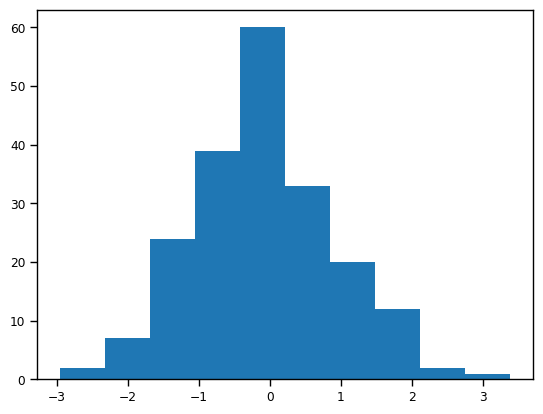

In [56]:
plt.hist(posterior_obs_resid[:,0])

In [57]:
summary_stats_df = basin_data_train[["prec","Tair_min","Tair_mean","Tair_max"]].groupby(basin_data_train.index.year).apply(lambda df: pd.DataFrame(wgen_summary_stats(df.index.values, df.prec.values, df.Tair_min.values, df.Tair_mean.values, df.Tair_max.values).reshape((1,-1)), columns=summary_stat_names)).reset_index().drop("level_1", axis=1)
summary_stats_df.describe()

time  prec_mean       rp95  norm wet days  \
count    41.000000  41.000000  41.000000      41.000000   
mean   1970.000000   1.841034  19.146120       0.464165   
std      11.979149   0.353711   4.528127       0.048617   
min    1950.000000   1.057300  13.098458       0.372603   
25%    1960.000000   1.523839  15.737223       0.427397   
50%    1970.000000   1.854292  18.018492       0.476712   
75%    1980.000000   2.098828  21.663124       0.498630   
max    1990.000000   2.655576  28.655827       0.546448   

       mean dry spell length  Tair_mean  Tair_range  Tair_skew  norm thaw days  
count              41.000000  41.000000   41.000000  41.000000       41.000000  
mean                3.295445   8.464806    7.665947   0.483585        0.852496  
std                 0.514934   0.769984    0.580928   0.026299        0.049317  
min                 2.553846   6.581241    6.549250   0.447778        0.753425  
25%                 2.885246   7.802209    7.438528   0.464979        0.816940  
50%                 3.216667   8.450788    7.685133   0.475402        0.852055  
75%                 3.649123   9.033152    8.031537   0.493390        0.887671  
max                 4.571429  10.052711    9.160261   0.537237        0.972603

In [58]:
obs_stats3 = obs_stats.at[1].add(5.0).at[2].add(-0.1).at[3].add(0.5)
obs_stats3 - obs_stats

Array([[ 0.        ],
       [ 5.        ],
       [-0.09999999],
       [ 0.5       ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]], dtype=float32)

In [59]:
# sample from recalibrated SBI posterior
obs_target = obs_stats3
sbi_samples3 = sbi_posterior.sample((200,), x=j2t(obs_target[:,0]))
sbi_samples3_mean = torch.quantile(sbi_samples3, q=0.5, axis=0, keepdims=True)*torch.ones((200,1))
sbi_posterior_sims3 = wgen_sbi(sbi_samples3_mean)

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

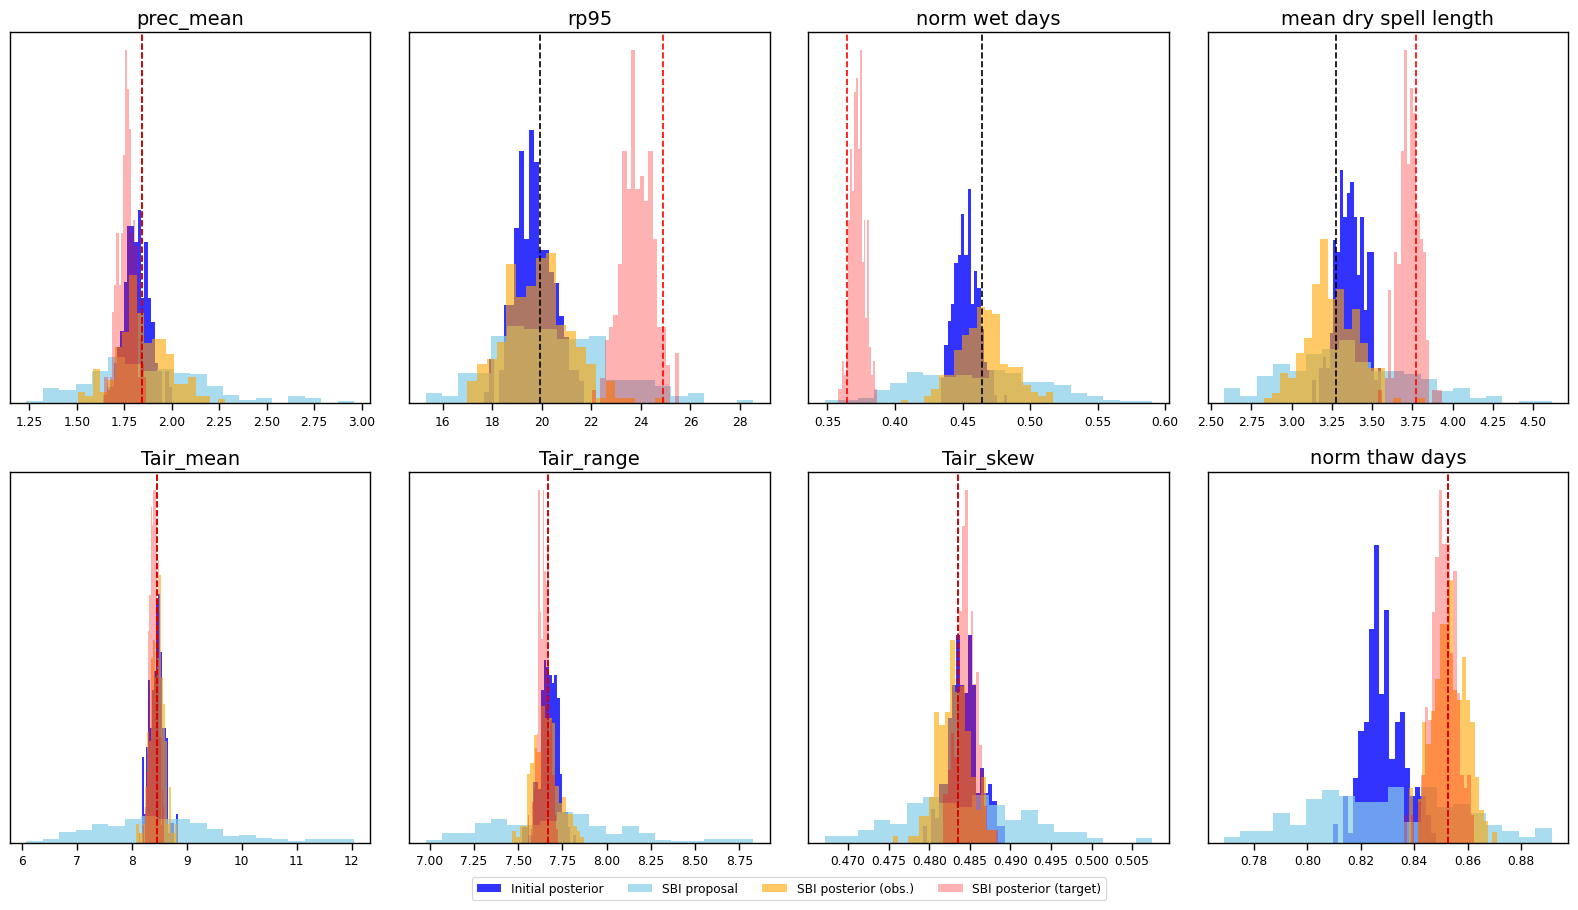

In [60]:
ncols = 4
nrows = 2
fig, axs = plt.subplots(nrows,ncols,figsize=(16,9))
for i in range(obs_stats.shape[0]):
    c = i % ncols
    r = i // ncols
    _,_,h1 = axs[r,c].hist(svi_posterior_sims.numpy()[:,i], bins=20, density=True, color='blue', alpha=0.8)
    _,_,h2 = axs[r,c].hist(svi_proposal_sims.numpy()[:,i], bins=20, density=True, color='skyblue', alpha=0.7)
    _,_,h3 = axs[r,c].hist(sbi_posterior_sims.numpy()[:,i], bins=20, density=True, color='orange', alpha=0.6)
    _,_,h4 = axs[r,c].hist(sbi_posterior_sims3.numpy()[:,i], bins=20, density=True, color='red', alpha=0.3)
    axs[r,c].axvline([obs_stats[i,:]], c='black', linestyle="--")
    axs[r,c].axvline([obs_target[i,:]], c='red', linestyle="--")
    axs[r,c].set_yticks([])
    axs[r,c].set_title(summary_stat_names[i])
for i in range(obs_stats.shape[0], ncols*nrows):
    c = i % ncols
    r = i // ncols
    fig.delaxes(axs[r,c])
labels = ["Initial posterior", "SBI proposal", "SBI posterior (obs.)", "SBI posterior (target)"]
fig.legend(handles=[h1,h2,h3,h4], labels=labels, ncol=4, loc="lower center", bbox_to_anchor=(0.5,-0.02))
plt.tight_layout()
plt.savefig("../plots/basin_6340800_sbi_posterior_rp95_wd_cdd_recalibrated.png")
plt.show()

In [61]:
sbi_posterior_samples_mean = sbi_samples.mean(axis=0, keepdims=True)
sbi_posterior_sims_mean = wgen_sbi(sbi_posterior_samples_mean)
sbi_posterior_sims_mean

tensor([[ 1.8457, 19.1253,  0.4719,  3.1900,  8.3043,  7.6414,  0.4813,  0.8474]])

In [62]:
sbi_params1 = wgen_prior.constrain(t2j(sbi_samples), as_dict=True)
sbi_params2 = wgen_prior.constrain(t2j(sbi_samples2), as_dict=True)
sbi_params3 = wgen_prior.constrain(t2j(sbi_samples3), as_dict=True)

In [63]:
sbi_predictive1 = Predictive(wgen.simulate, posterior_samples=sbi_params1, parallel=True)
sbi_preds1 = sbi_predictive1(prng)

In [64]:
sbi_predictive2 = Predictive(wgen.simulate, posterior_samples=sbi_params2, parallel=True)
sbi_preds2 = sbi_predictive2(prng)

In [65]:
sbi_predictive3 = Predictive(wgen.simulate, posterior_samples=sbi_params3, parallel=True)
sbi_preds3 = sbi_predictive3(prng)

In [66]:
sbi_preds1["Tavg"].shape

(200, 14975, 1)

In [67]:
wgen.obs['Tavg'].shape

(1, 14975)

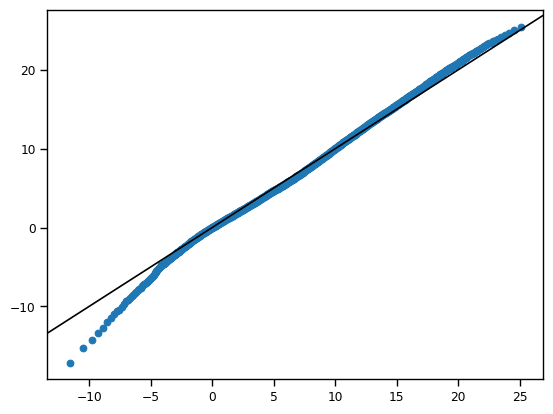

In [68]:
Tavg_preds1 = sbi_preds1["Tavg"].flatten().sort()
Tavg_obs1 = wgen.obs["Tavg"].squeeze().sort()
plt.scatter(np.quantile(Tavg_preds1, np.arange(0.001,0.999,0.001)), np.quantile(Tavg_obs1, np.arange(0.001,0.999,0.001)))
plt.axline((0,0),slope=1,color="black")

In [69]:
import xarray as xr

def to_xarray(data, preds):
    timestamps = data.index
    Tavg_sims = xr.DataArray(preds["Tavg"].squeeze(), dims=("sample","time"), coords={"time": timestamps.values}, name="Tavg_sim")
    Tmin_sims = xr.DataArray(preds["Tmin"].squeeze(), dims=("sample","time"), coords={"time": timestamps.values}, name="Tmin_sim")
    Tmax_sims = xr.DataArray(preds["Tmax"].squeeze(), dims=("sample","time"), coords={"time": timestamps.values}, name="Tmax_sim")
    prec_sims = xr.DataArray(preds["prec"].squeeze(), dims=("sample","time"), coords={"time": timestamps.values}, name="prec_sim")
    obs = data.to_xarray().astype(np.float32)
    return xr.merge([Tavg_sims, Tmin_sims, Tmax_sims, prec_sims, obs])

In [70]:
sbi_sims1_arr = to_xarray(basin_data_train[["Tair_mean","Tair_min","Tair_max","prec"]].iloc[wgen.first_valid_idx:,:], sbi_preds1)
sbi_sims2_arr = to_xarray(basin_data_train[["Tair_mean","Tair_min","Tair_max","prec"]].iloc[wgen.first_valid_idx:,:], sbi_preds2)
sbi_sims3_arr = to_xarray(basin_data_train[["Tair_mean","Tair_min","Tair_max","prec"]].iloc[wgen.first_valid_idx:,:], sbi_preds3)

In [72]:
sbi_sims1_arr.to_netcdf("../data/products/wgen_glm_v3_basin=6340800_sbi_obs_stats.nc")
sbi_sims2_arr.to_netcdf("../data/products/wgen_glm_v3_basin=6340800_sbi_rand_stats.nc")
sbi_sims3_arr.to_netcdf("../data/products/wgen_glm_v3_basin=6340800_sbi_tuned_stats.nc")

In [73]:
sbi_sims1_arr

<xarray.Dataset> Size: 48MB
Dimensions:    (time: 14975, sample: 200)
Coordinates:
  * time       (time) datetime64[ns] 120kB 1950-01-01 1950-01-02 ... 1990-12-31
Dimensions without coordinates: sample
Data variables:
    Tavg_sim   (sample, time) float32 12MB 2.318 3.241 2.972 ... 0.9073 -0.04229
    Tmin_sim   (sample, time) float32 12MB -4.668 1.906 ... -0.1766 -1.746
    Tmax_sim   (sample, time) float32 12MB 9.926 5.33 5.359 ... 2.711 3.549
    prec_sim   (sample, time) float32 12MB 0.0 0.0 5.898 4.239 ... 0.0 0.0 0.0
    Tair_mean  (time) float32 60kB -4.592 -0.241 1.185 ... 4.872 5.884 4.019
    Tair_min   (time) float32 60kB -5.684 -5.416 -0.2187 ... 0.4121 3.41 1.914
    Tair_max   (time) float32 60kB -2.228 0.9776 2.022 ... 6.171 9.602 6.355
    prec       (time) float32 60kB 0.0 14.84 3.41 2.306 ... 0.0 4.842 0.0 2.197